# прогнозирование спроса на новые товары
#### иса гадаев павел манякин георгий дудин при поддержке retro goldwyn mayer

### chapter 1: eda&data cleaning

In [2]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.model_selection as skr
import statsmodels.formula.api as sm
import statsmodels.api as sm2
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.graphics.regressionplots as smg
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from typing import List, Dict, Tuple

%matplotlib inline

sns.set()

In [84]:
def dataframe_new_stats(df: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([df.isnull().sum().rename('null'), (df.isnull().sum() / df.shape[0] * 100).rename('%null'), \
        (df == 0).sum().rename('zero'), ((df == 0).sum() / df.shape[0] * 100).rename('%zero'), df.nunique().rename('unique')], axis=1)

In [3]:
test_df = pd.read_csv("hse-dab-naf-23/test.csv")
pd.set_option('display.max_columns', None)

test_df.head(10)

product_id  location_id   period_dt     id
0       22939         1162  2019-12-30     16
1       23162         1162  2019-12-30   7867
2       23163         1162  2019-12-16   8667
3       23632          798  2019-12-23  14835
4       23633         1347  2019-12-30  14959
5       24007          764  2019-12-16  24820
6       32646          380  2019-12-16  35688
7       34846          866  2019-12-23  41293
8       34847          764  2019-12-16  41644
9       34847         1034  2019-12-30  41646

In [4]:
train_df = pd.read_csv("hse-dab-naf-23/train.csv", sep=',')

train_df.head(10)

period_dt  location_id  product_id  demand  PROMO1_FLAG  PROMO2_FLAG  \
0  2019-12-30        425.0     22939.0     NaN          0.0          0.0   
1  2019-12-30        525.0     22939.0     NaN          0.0          0.0   
2  2019-12-30        557.0     22939.0     NaN          0.0          0.0   
3  2019-12-30        562.0     22939.0     NaN          0.0          0.0   
4  2019-12-30        637.0     22939.0     NaN          0.0          0.0   
5  2019-12-16        637.0     22939.0     NaN          0.0          0.0   
6  2019-12-09        637.0     22939.0     NaN          0.0          0.0   
7  2019-12-30        657.0     22939.0     NaN          0.0          0.0   
8  2019-12-23        657.0     22939.0     NaN          0.0          0.0   
9  2019-12-16        764.0     22939.0     NaN          0.0          0.0   

   PRICE_REGULAR  PRICE_AFTER_DISC  NUM_CONSULTANT  AUTORIZATION_FLAG  id  
0         3649.0           2736.75             0.0                0.0   1  
1         3649.0           2371.85             0.0                1.0   3  
2         3649.0           2736.75             0.0                1.0   5  
3         3649.0           2736.75             0.0                0.0   7  
4         3649.0           3101.65             0.0                0.0   9  
5         3649.0           3101.65             0.0                0.0  10  
6         3649.0           3101.65             0.0                1.0  11  
7         3649.0           2736.75             0.0                1.0  12  
8         3649.0           2736.75             0.0                1.0  13  
9         3649.0           2371.85             0.0                1.0  14

In [5]:
product_df = pd.read_csv("hse-dab-naf-23/PRODUCT.csv", sep=';')

product_df.head(10)

PRODUCT_RK  PRODUCT_LVL_RK6  PRODUCT_LVL_RK5  PRODUCT_LVL_RK4  \
0       11316            10224            10198           113533   
1       11317            10224            10198           113533   
2       11318            10224            10198           113533   
3       11319            10224            10198           113533   
4       11320            10224            10198           113533   
5       11321            10224            10198           113533   
6       11322            10224            10198           113533   
7       11323            10224            10198           113533   
8       11324            10224            10198           113533   
9       11325            10224            10198           113533   

   PRODUCT_LVL_RK3  PRODUCT_LVL_RK2  PRODUCT_LVL_RK1  SALES_INTRODUCTION_DT  \
0            10125             9711                1                    NaN   
1            10125             9711                1                    NaN   
2            10125             9711                1                    NaN   
3            10125             9711                1                    NaN   
4            10125             9711                1                    NaN   
5            10125             9711                1                    NaN   
6            10125             9711                1                    NaN   
7            10125             9711                1                    NaN   
8            10125             9711                1                    NaN   
9            10125             9711                1                    NaN   

   SALES_DISCONTINUED_DT     VALID_FROM_DTTM       VALID_TO_DTTM  \
0                    NaN  15Mar2018:14:08:14  01Jan5999:00:00:00   
1                    NaN  15Mar2018:14:08:14  01Jan5999:00:00:00   
2                    NaN  15Mar2018:14:08:14  01Jan5999:00:00:00   
3                    NaN  15Mar2018:14:08:14  01Jan5999:00:00:00   
4                    NaN  15Mar2018:14:08:14  01Jan5999:00:00:00   
5                    NaN  15Mar2018:14:08:14  01Jan5999:00:00:00   
6                    NaN  15Mar2018:14:08:14  01Jan5999:00:00:00   
7                    NaN  15Mar2018:14:08:14  01Jan5999:00:00:00   
8                    NaN  15Mar2018:14:08:14  01Jan5999:00:00:00   
9                    NaN  15Mar2018:14:08:14  01Jan5999:00:00:00   

       PROCESSED_DTTM               PRODUCT_ADK_hashing  \
0  03Jan2020:07:01:13  A5C279811C3210EB8CFD7027E51ADAC4   
1  03Jan2020:07:01:13  A5C279811C3210EB8CFD7027E51ADAC4   
2  03Jan2020:07:01:13  A5C279811C3210EB8CFD7027E51ADAC4   
3  03Jan2020:07:01:13  A5C279811C3210EB8CFD7027E51ADAC4   
4  03Jan2020:07:01:13  A5C279811C3210EB8CFD7027E51ADAC4   
5  03Jan2020:07:01:13  A5C279811C3210EB8CFD7027E51ADAC4   
6  03Jan2020:07:01:13  A5C279811C3210EB8CFD7027E51ADAC4   
7  03Jan2020:07:01:13  A5C279811C3210EB8CFD7027E51ADAC4   
8  03Jan2020:07:01:13  A5C279811C3210EB8CFD7027E51ADAC4   
9  03Jan2020:07:01:13  A5C279811C3210EB8CFD7027E51ADAC4   

                 PRODUCT_ID_hashing                PRODUCT_NM_hashing  \
0  419E9D9BC063B0471F98BA65344206C1  4E055B6F492B9AAD0A791B9D5D3A165E   
1  1DA3C3531BF38D301A87CE1C24D69CCC  1B9D450C5EC57EF73BB95CF2F4A57F12   
2  1D5D603CA26D53A857A179C1A8125DDE  883037FC8F696C04C977F6ACF9850E64   
3  785B6DFCEBB5BB6672AF54B3AA2E1E2D  8C598C76550A0F110E834A95B2E53D05   
4  68E617670B0084989F1B22F8B349C53B  2220CE0E8E8333E40F402CB334034860   
5  9ACE7F4DE9D07CA01272E6686B0ABBC9  83597F6313A29DB4C9B774216FBB61B0   
6  279E4EB5DFB02316662CE3E713024A64  43E321DCFE123199F1A86B14D7C261FB   
7  EFA67253A55F2ADF86DB106D5CE01373  1C89E5F4F2CA902496BD0EA36F58574E   
8  D281D3759B2B6A104DC25499E6317DCD  4242397DDD7A2AB85F7018816D66CB69   
9  D1A3340379FEE0CF35654C30052CDFC7  D5055796D08C5A3CFE09BD2295880025   

               PRODUCT_DESC_hashing               LANGUAGE_CD_hashing  \
0  E5E1FA47D79C1D573A65E2A4D17F6E6E  3A73A94D029959DC71AF0AFCB9F2189E   
1  E5E1FA47D79C1D573A65E2A4D17F6E6E

In [6]:
location_df = pd.read_csv("hse-dab-naf-23/LOCATION.csv", sep=';')

location_df.head(10)

STORE_LOCATION_RK  STORE_LOCATION_LVL_RK4  STORE_LOCATION_LVL_RK3  \
0                277                     124                     124   
1                278                     124                     124   
2                279                     183                     183   
3                280                     211                     211   
4                281                     221                     221   
5                282                     201                     201   
6                283                     197                     197   
7                284                     228                     228   
8                285                     222                     222   
9                286                     230                     230   

   STORE_LOCATION_LVL_RK2  STORE_LOCATION_LVL_RK1  STORE_OPEN_DTTM  \
0                      19                       1              NaN   
1                      19                       1              NaN   
2                      20                       1              NaN   
3                      12                       1              NaN   
4                       3                       1              NaN   
5                      13                       1              NaN   
6                      20                       1              NaN   
7                       4                       1              NaN   
8                      16                       1              NaN   
9                      22                       1              NaN   

   STORE_CLOSURE_DTTM     VALID_FROM_DTTM       VALID_TO_DTTM  \
0                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
1                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
2                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
3                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
4                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
5                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
6                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
7                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
8                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
9                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   

       PROCESSED_DTTM        STORE_LOCATION_ADK_hashing  \
0  03Jan2020:07:00:25  181F921CC957DF5CEC4BF2C18E4A371F   
1  03Jan2020:07:00:25  181F921CC957DF5CEC4BF2C18E4A371F   
2  03Jan2020:07:00:25  181F921CC957DF5CEC4BF2C18E4A371F   
3  03Jan2020:07:00:25  181F921CC957DF5CEC4BF2C18E4A371F   
4  03Jan2020:07:00:25  181F921CC957DF5CEC4BF2C18E4A371F   
5  03Jan2020:07:00:25  181F921CC957DF5CEC4BF2C18E4A371F   
6  03Jan2020:07:00:25  181F921CC957DF5CEC4BF2C18E4A371F   
7  03Jan2020:07:00:25  181F921CC957DF5CEC4BF2C18E4A371F   
8  03Jan2020:07:00:25  181F921CC957DF5CEC4BF2C18E4A371F   
9  03Jan2020:07:00:25  181F921CC957DF5CEC4BF2C18E4A371F   

          STORE_LOCATION_ID_hashing         STORE_LOCATION_NM_hashing  \
0  70BAE846650DAC2A5E3F42EE589903CB  1FD625282F5BB57C4CEF60EC78AB2BD5   
1  FDD55E57DC6CA449FFBB53DFC5960C74  7A390B982C99DE39EB8BDE09448B1B56   
2  4A2799652F7E55AAEB84CF5EE3529681  7073BCFA4AA43DA302960844ED91B947   
3  DCACF6ED820808B49274DF0C5A578BB1  6AE5DB50206FCFF5E31732ACC49EBCAC   
4  539A0CCDA2A1F9A6AAC68E873FFA4742  D5218D062026DE919488A07356FA0EFF   
5  44416EF0C42EF86F5A6D6AA5B622EA11  2B22FC837613917BD0581AF672EC3709   
6  4D3B0C39BDE0042B20F5BED62E2F2AEA  0F34B92E08FFC272C6B9BC2B182E2179   
7  305297BE0C9F6FAE8F5CF9212ADE0A07  AC2CCAC8A349EE6CA5845BB6D7A11669   
8  AD8457779205C94AB5E8F094A9CBD363  404F93478EB2782945F6D9AA369DFB03   
9  548FD4DCDE661F120533F5D8007F47BE  76E0315DEB015E2224F8A745E2E5F7EE   

        STORE_LOCATION_DESC_hashing               LANGUAGE_CD_hashing  \
0  E5E1FA47D79C1D573A65E2A4D17F6E6E  3A73A94D029959DC71AF0AFCB9F2189E   
1  E5E1FA47D79C1D573A65E2A4D17F6E6E  3A73A94D029959DC71AF0AFCB9F2189E   
2  E5E1FA47D79C1D573A65E2A4D17F6E6E  3A73A94D02995

In [7]:
train_loc = pd.merge(train_df, location_df, left_on='location_id', right_on='STORE_LOCATION_RK')
train_merged = pd.merge(train_loc, product_df, left_on='product_id', right_on='PRODUCT_RK')

train_merged.head(10)

period_dt  location_id  product_id    demand  PROMO1_FLAG  PROMO2_FLAG  \
0  2019-12-30        425.0     22939.0       NaN          0.0          0.0   
1  2017-01-02        425.0     22939.0  0.005479          1.0          0.0   
2  2017-02-27        425.0     22939.0  1.000000          1.0          0.0   
3  2017-03-20        425.0     22939.0  0.002740          0.0          0.0   
4  2018-01-01        425.0     22939.0  0.002740          1.0          0.0   
5  2018-01-08        425.0     22939.0  1.021918          0.0          0.0   
6  2018-01-15        425.0     22939.0  0.022152          0.0          0.0   
7  2018-01-22        425.0     22939.0  0.022152          0.0          0.0   
8  2018-01-29        425.0     22939.0  0.022152          0.0          0.0   
9  2018-02-05        425.0     22939.0  0.022152          0.0          0.0   

   PRICE_REGULAR  PRICE_AFTER_DISC  NUM_CONSULTANT  AUTORIZATION_FLAG  id  \
0    3649.000000       2736.750000             0.0                0.0   1   
1    3399.000000       2549.250000             0.0                1.0  75   
2    3399.000000       2549.250000             0.0                1.0  76   
3    3399.000000       2549.250000             0.0                1.0  77   
4    3399.000000       2549.250000             0.0                1.0  78   
5    3506.142857       2629.607143             0.0                1.0  79   
6    3549.000000       2661.750000             0.0                1.0  80   
7    3549.000000       2661.750000             0.0                1.0  81   
8    3549.000000       2661.750000             0.0                1.0  82   
9    3549.000000       2661.750000             0.0                1.0  83   

   STORE_LOCATION_RK  STORE_LOCATION_LVL_RK4  STORE_LOCATION_LVL_RK3  \
0                425                     203                     203   
1                425                     203                     203   
2                425                     203                     203   
3                425                     203                     203   
4                425                     203                     203   
5                425                     203                     203   
6                425                     203                     203   
7                425                     203                     203   
8                425                     203                     203   
9                425                     203                     203   

   STORE_LOCATION_LVL_RK2  STORE_LOCATION_LVL_RK1  STORE_OPEN_DTTM  \
0                      10                       1              NaN   
1                      10                       1              NaN   
2                      10                       1              NaN   
3                      10                       1              NaN   
4                      10                       1              NaN   
5                      10                       1              NaN   
6                      10                       1              NaN   
7                      10                       1              NaN   
8                      10                       1              NaN   
9                      10                       1              NaN   

   STORE_CLOSURE_DTTM   VALID_FROM_DTTM_x     VALID_TO_DTTM_x  \
0                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
1                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
2                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
3                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
4                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
5                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
6                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
7                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
8                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
9                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   

     PROCESSED_DT

In [89]:
train_merged.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284119 entries, 0 to 284118
Data columns (total 126 columns):
 #    Column                            Dtype  
---   ------                            -----  
 0    period_dt                         object 
 1    location_id                       float64
 2    product_id                        float64
 3    demand                            float64
 4    PROMO1_FLAG                       float64
 5    PROMO2_FLAG                       float64
 6    PRICE_REGULAR                     float64
 7    PRICE_AFTER_DISC                  float64
 8    NUM_CONSULTANT                    float64
 9    AUTORIZATION_FLAG                 float64
 10   id                                int64  
 11   STORE_LOCATION_RK                 int64  
 12   STORE_LOCATION_LVL_RK4            int64  
 13   STORE_LOCATION_LVL_RK3            int64  
 14   STORE_LOCATION_LVL_RK2            int64  
 15   STORE_LOCATION_LVL_RK1            int64  
 16   STORE_OPEN_DTTM   

- фпесду хэшированное
- смотреть выше чем рк5 по продакту бессмысленно

In [8]:
filtered_merged = train_merged[train_merged.columns.difference(list(train_merged.filter(regex='.*_hashing.*')), sort=False)]

filtered_merged.head(10)

period_dt  location_id  product_id    demand  PROMO1_FLAG  PROMO2_FLAG  \
0  2019-12-30        425.0     22939.0       NaN          0.0          0.0   
1  2017-01-02        425.0     22939.0  0.005479          1.0          0.0   
2  2017-02-27        425.0     22939.0  1.000000          1.0          0.0   
3  2017-03-20        425.0     22939.0  0.002740          0.0          0.0   
4  2018-01-01        425.0     22939.0  0.002740          1.0          0.0   
5  2018-01-08        425.0     22939.0  1.021918          0.0          0.0   
6  2018-01-15        425.0     22939.0  0.022152          0.0          0.0   
7  2018-01-22        425.0     22939.0  0.022152          0.0          0.0   
8  2018-01-29        425.0     22939.0  0.022152          0.0          0.0   
9  2018-02-05        425.0     22939.0  0.022152          0.0          0.0   

   PRICE_REGULAR  PRICE_AFTER_DISC  NUM_CONSULTANT  AUTORIZATION_FLAG  id  \
0    3649.000000       2736.750000             0.0                0.0   1   
1    3399.000000       2549.250000             0.0                1.0  75   
2    3399.000000       2549.250000             0.0                1.0  76   
3    3399.000000       2549.250000             0.0                1.0  77   
4    3399.000000       2549.250000             0.0                1.0  78   
5    3506.142857       2629.607143             0.0                1.0  79   
6    3549.000000       2661.750000             0.0                1.0  80   
7    3549.000000       2661.750000             0.0                1.0  81   
8    3549.000000       2661.750000             0.0                1.0  82   
9    3549.000000       2661.750000             0.0                1.0  83   

   STORE_LOCATION_RK  STORE_LOCATION_LVL_RK4  STORE_LOCATION_LVL_RK3  \
0                425                     203                     203   
1                425                     203                     203   
2                425                     203                     203   
3                425                     203                     203   
4                425                     203                     203   
5                425                     203                     203   
6                425                     203                     203   
7                425                     203                     203   
8                425                     203                     203   
9                425                     203                     203   

   STORE_LOCATION_LVL_RK2  STORE_LOCATION_LVL_RK1  STORE_OPEN_DTTM  \
0                      10                       1              NaN   
1                      10                       1              NaN   
2                      10                       1              NaN   
3                      10                       1              NaN   
4                      10                       1              NaN   
5                      10                       1              NaN   
6                      10                       1              NaN   
7                      10                       1              NaN   
8                      10                       1              NaN   
9                      10                       1              NaN   

   STORE_CLOSURE_DTTM   VALID_FROM_DTTM_x     VALID_TO_DTTM_x  \
0                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
1                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
2                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
3                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
4                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
5                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
6                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
7                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
8                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   
9                 NaN  15Mar2018:14:08:08  01Jan5999:00:00:00   

     PROCESSED_DT

In [9]:
import matplotlib.ticker as ticker

def mass_hist_plot(df: pd.core.frame.DataFrame, cols: List) -> None:
    cum = math.floor(len(cols) / 3)
    muc = len(cols) % 3
    fig, ax = plt.subplots(cum, 3, figsize=(13, 5*cum))
    ax = ax.flatten()

    if muc != 0:
        fig_add, ax_add = plt.subplots(1, muc, figsize=(11, 5))
        ax = np.append(ax, ax_add)

    for i in range(len(cols)):
        plot = sns.histplot(df[cols[i]], ax=ax[i])
        if i % 3:
            plot.set_ylabel("")


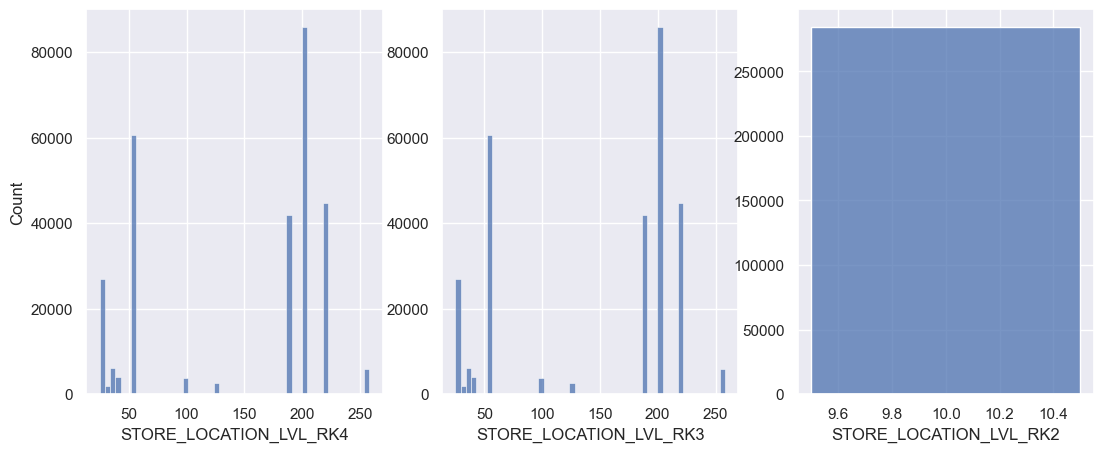

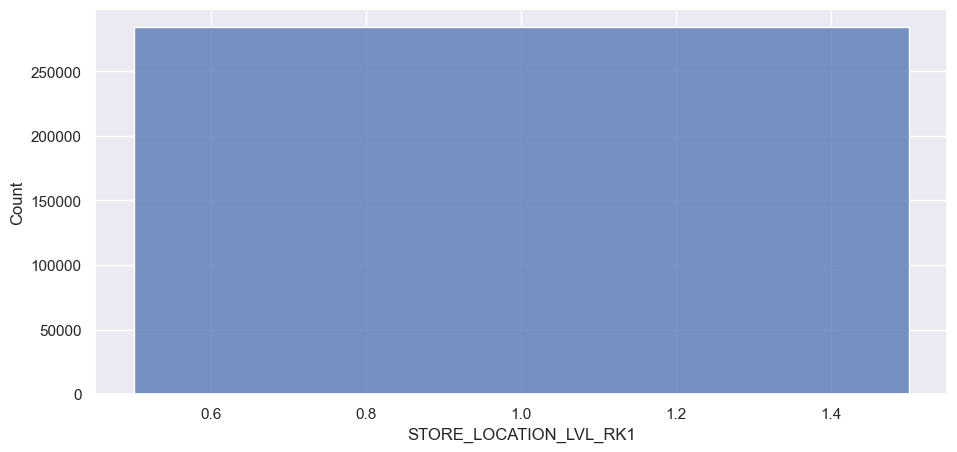

In [10]:
mass_hist_plot(filtered_merged, ['STORE_LOCATION_LVL_RK4', 'STORE_LOCATION_LVL_RK3', 'STORE_LOCATION_LVL_RK2', 'STORE_LOCATION_LVL_RK1'])

In [11]:
def quick_boxplot(df: pd.core.frame.DataFrame, qual: str, target: str, vertical=False, ylim=0, dm1=10, dm2=6):
    fig, ax = plt.subplots(figsize=(dm1, dm2))

    sns.boxplot(x=qual, y=target, data=df, ax=ax)
    plt.ticklabel_format(style='plain', axis='y',useOffset=False)
    if ylim:
        plt.ylim(0, ylim)
    
    if vertical:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

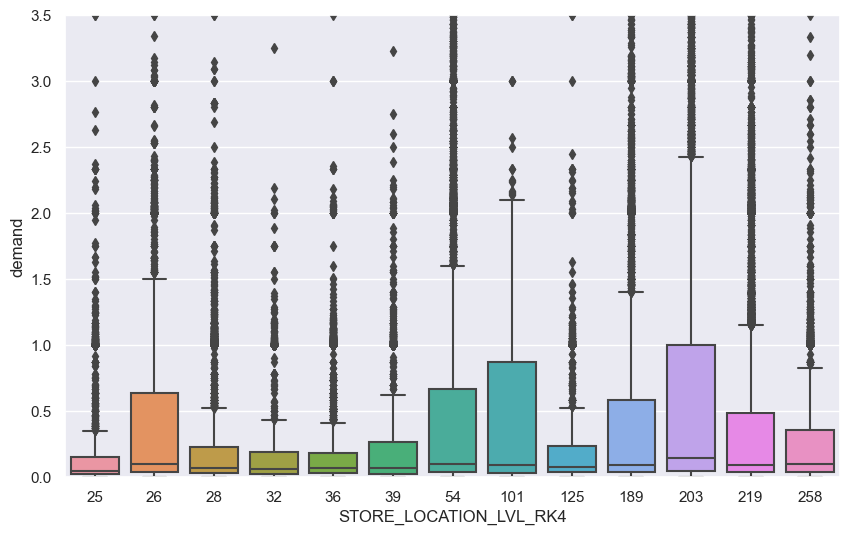

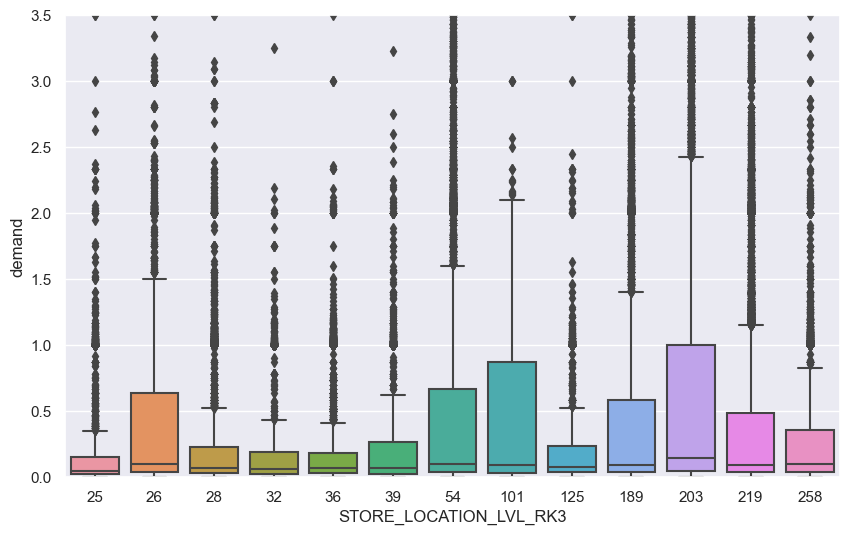

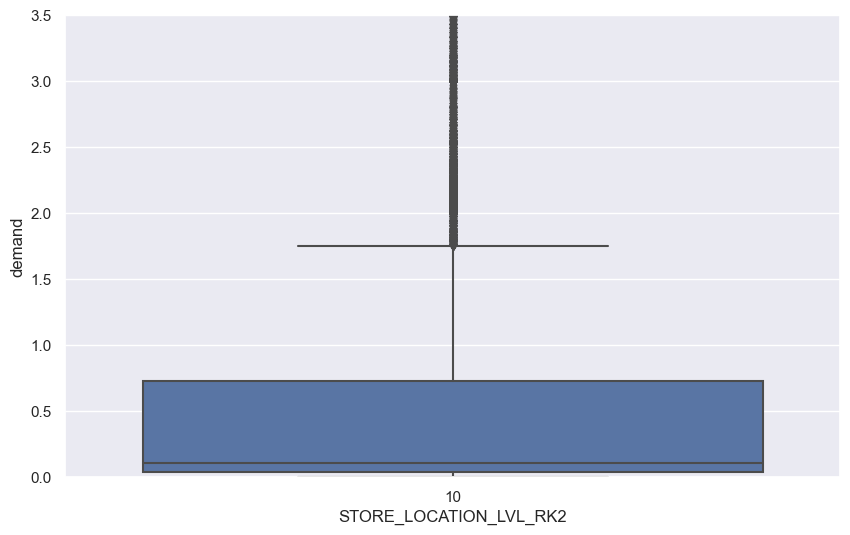

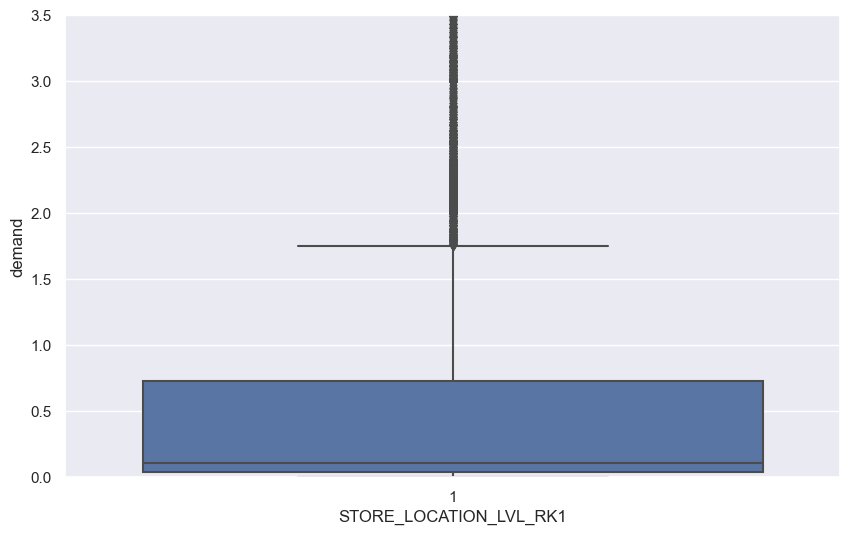

In [12]:
for col in ['STORE_LOCATION_LVL_RK4', 'STORE_LOCATION_LVL_RK3', 'STORE_LOCATION_LVL_RK2', 'STORE_LOCATION_LVL_RK1']:
    quick_boxplot(filtered_merged, col, 'demand', vertical=False, ylim=3.5)

- drop bullshit 
- filter features as has been advised(VALID_FROM_* are useless, according to the supervisor)
- drop duplicate id vars

In [14]:
filtered_merged

period_dt  location_id  product_id    demand  PROMO1_FLAG  \
0       2019-12-30        425.0     22939.0       NaN          0.0   
1       2017-01-02        425.0     22939.0  0.005479          1.0   
2       2017-02-27        425.0     22939.0  1.000000          1.0   
3       2017-03-20        425.0     22939.0  0.002740          0.0   
4       2018-01-01        425.0     22939.0  0.002740          1.0   
...            ...          ...         ...       ...          ...   
284114  2017-12-04        555.0     40696.0  0.023973          0.0   
284115  2017-12-11        555.0     40696.0  0.020548          0.0   
284116  2018-01-01        555.0     40696.0  0.013699          1.0   
284117  2018-01-08        555.0     40696.0  0.023973          0.0   
284118  2019-08-12        555.0     41686.0  1.000000          1.0   

        PROMO2_FLAG  PRICE_REGULAR  PRICE_AFTER_DISC  NUM_CONSULTANT  \
0               0.0         3649.0           2736.75             0.0   
1               0.0         3399.0           2549.25             0.0   
2               0.0         3399.0           2549.25             0.0   
3               0.0         3399.0           2549.25             0.0   
4               0.0         3399.0           2549.25             0.0   
...             ...            ...               ...             ...   
284114          0.0         1499.0            974.39             0.0   
284115          0.0         1499.0            974.39             0.0   
284116          0.0         1499.0            974.39             0.0   
284117          0.0         1499.0            974.39             0.0   
284118          0.0         1399.0            699.50             0.0   

        AUTORIZATION_FLAG      id  STORE_LOCATION_RK  STORE_LOCATION_LVL_RK4  \
0                     0.0       1                425                     203   
1                     1.0      75                425                     203   
2                     1.0      76                425                     203   
3                     1.0      77                425                     203   
4                     1.0      78                425                     203   
...                   ...     ...                ...                     ...   
284114                0.0  263653                555                     258   
284115                0.0  263654                555                     258   
284116                0.0  263655                555                     258   
284117                0.0  263656                555                     258   
284118                0.0  288470                555                     258   

        STORE_LOCATION_LVL_RK3  STORE_LOCATION_LVL_RK2  \
0                          203                      10   
1                          203                      10   
2                          203                      10   
3                          203                      10   
4                          203                      10   
...                        ...                     ...   
284114                     258                      10   
284115                     258                      10   
284116                     258                      10   
284117                     258                      10   
284118                     258                      10   

        STORE_LOCATION_LVL_RK1  STORE_OPEN_DTTM  STORE_CLOSURE_DTTM  \
0                            1              NaN                 NaN   
1                            1              NaN                 NaN   
2                            1              NaN                 NaN   
3                            1              NaN                 NaN   
4                            1              NaN                 NaN   
...                        ...              ...                 ...   
284114                       1              NaN                 NaN   
284115                       1              NaN                 NaN   
284116

In [15]:
dataframe_new_stats(filtered_merged)

null       %null    zero      %zero  unique
period_dt                    0    0.000000       0   0.000000     156
location_id                  0    0.000000       0   0.000000      41
product_id                   0    0.000000       0   0.000000    2140
demand                    9648    3.395760    5238   1.843594   16291
PROMO1_FLAG               1797    0.632481  163979  57.714901       4
PROMO2_FLAG               1797    0.632481  281604  99.114808       2
PRICE_REGULAR             6819    2.400051       0   0.000000    2717
PRICE_AFTER_DISC          8435    2.968826       0   0.000000   13080
NUM_CONSULTANT            1797    0.632481  259352  91.282878      11
AUTORIZATION_FLAG         1797    0.632481   35524  12.503212       2
id                           0    0.000000       0   0.000000  284119
STORE_LOCATION_RK            0    0.000000       0   0.000000      41
STORE_LOCATION_LVL_RK4       0    0.000000       0   0.000000      13
STORE_LOCATION_LVL_RK3       0    0.000000       0   0.000000      13
STORE_LOCATION_LVL_RK2       0    0.000000       0   0.000000       1
STORE_LOCATION_LVL_RK1       0    0.000000       0   0.000000       1
STORE_OPEN_DTTM         284119  100.000000       0   0.000000       0
STORE_CLOSURE_DTTM      284119  100.000000       0   0.000000       0
VALID_FROM_DTTM_x            0    0.000000       0   0.000000       1
VALID_TO_DTTM_x              0    0.000000       0   0.000000       1
PROCESSED_DTTM_x             0    0.000000       0   0.000000       1
PRODUCT_RK                   0    0.000000       0   0.000000    2140
PRODUCT_LVL_RK6              0    0.000000       0   0.000000      36
PRODUCT_LVL_RK5              0    0.000000       0   0.000000       1
PRODUCT_LVL_RK4              0    0.000000       0   0.000000       1
PRODUCT_LVL_RK3              0    0.000000       0   0.000000       1
PRODUCT_LVL_RK2              0    0.000000       0   0.000000       1
PRODUCT_LVL_RK1              0    0.000000       0   0.000000       1
SALES_INTRODUCTION_DT   284119  100.000000       0   0.000000       0
SALES_DISCONTINUED_DT   284119  100.000000       0   0.000000       0
VALID_FROM_DTTM_y            0    0.000000       0   0.000000      19
VALID_TO_DTTM_y              0    0.000000       0   0.000000       1
PROCESSED_DTTM_y             0    0.000000       0   0.000000       1

In [16]:
filtered_merged2 = filtered_merged.drop(['STORE_LOCATION_LVL_RK3', 'STORE_LOCATION_LVL_RK2', 'STORE_LOCATION_LVL_RK1', 'STORE_LOCATION_RK', 'PRODUCT_LVL_RK4',\
    'VALID_FROM_DTTM_y', 'VALID_FROM_DTTM_x', 'PRODUCT_LVL_RK3', 'PRODUCT_LVL_RK2', 'PRODUCT_LVL_RK1', 'PRODUCT_RK', 'PRODUCT_LVL_RK5',\
    'VALID_TO_DTTM_y', 'VALID_TO_DTTM_x'], axis=1, inplace=False)

filtered_merged2.head(10)

period_dt  location_id  product_id    demand  PROMO1_FLAG  PROMO2_FLAG  \
0  2019-12-30        425.0     22939.0       NaN          0.0          0.0   
1  2017-01-02        425.0     22939.0  0.005479          1.0          0.0   
2  2017-02-27        425.0     22939.0  1.000000          1.0          0.0   
3  2017-03-20        425.0     22939.0  0.002740          0.0          0.0   
4  2018-01-01        425.0     22939.0  0.002740          1.0          0.0   
5  2018-01-08        425.0     22939.0  1.021918          0.0          0.0   
6  2018-01-15        425.0     22939.0  0.022152          0.0          0.0   
7  2018-01-22        425.0     22939.0  0.022152          0.0          0.0   
8  2018-01-29        425.0     22939.0  0.022152          0.0          0.0   
9  2018-02-05        425.0     22939.0  0.022152          0.0          0.0   

   PRICE_REGULAR  PRICE_AFTER_DISC  NUM_CONSULTANT  AUTORIZATION_FLAG  id  \
0    3649.000000       2736.750000             0.0                0.0   1   
1    3399.000000       2549.250000             0.0                1.0  75   
2    3399.000000       2549.250000             0.0                1.0  76   
3    3399.000000       2549.250000             0.0                1.0  77   
4    3399.000000       2549.250000             0.0                1.0  78   
5    3506.142857       2629.607143             0.0                1.0  79   
6    3549.000000       2661.750000             0.0                1.0  80   
7    3549.000000       2661.750000             0.0                1.0  81   
8    3549.000000       2661.750000             0.0                1.0  82   
9    3549.000000       2661.750000             0.0                1.0  83   

   STORE_LOCATION_LVL_RK4  STORE_OPEN_DTTM  STORE_CLOSURE_DTTM  \
0                     203              NaN                 NaN   
1                     203              NaN                 NaN   
2                     203              NaN                 NaN   
3                     203              NaN                 NaN   
4                     203              NaN                 NaN   
5                     203              NaN                 NaN   
6                     203              NaN                 NaN   
7                     203              NaN                 NaN   
8                     203              NaN                 NaN   
9                     203              NaN                 NaN   

     PROCESSED_DTTM_x  PRODUCT_LVL_RK6  SALES_INTRODUCTION_DT  \
0  03Jan2020:07:00:25             3876                    NaN   
1  03Jan2020:07:00:25             3876                    NaN   
2  03Jan2020:07:00:25             3876                    NaN   
3  03Jan2020:07:00:25             3876                    NaN   
4  03Jan2020:07:00:25             3876                    NaN   
5  03Jan2020:07:00:25             3876                    NaN   
6  03Jan2020:07:00:25             3876                    NaN   
7  03Jan2020:07:00:25             3876                    NaN   
8  03Jan2020:07:00:25             3876                    NaN   
9  03Jan2020:07:00:25             3876                    NaN   

   SALES_DISCONTINUED_DT    PROCESSED_DTTM_y  
0                    NaN  03Jan2020:07:01:13  
1                    NaN  03Jan2020:07:01:13  
2                    NaN  03Jan2020:07:01:13  
3                    NaN  03Jan2020:07:01:13  
4                    NaN  03Jan2020:07:01:13  
5                    NaN  03Jan2020:07:01:13  
6                    NaN  03Jan2020:07:01:13  
7                    NaN  03Jan2020:07:01:13  
8                    NaN  03Jan2020:07:01:13  
9                    NaN  03Jan2020:07:01:13

In [17]:
filtered_merged2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284119 entries, 0 to 284118
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   period_dt               284119 non-null  object 
 1   location_id             284119 non-null  float64
 2   product_id              284119 non-null  float64
 3   demand                  274471 non-null  float64
 4   PROMO1_FLAG             282322 non-null  float64
 5   PROMO2_FLAG             282322 non-null  float64
 6   PRICE_REGULAR           277300 non-null  float64
 7   PRICE_AFTER_DISC        275684 non-null  float64
 8   NUM_CONSULTANT          282322 non-null  float64
 9   AUTORIZATION_FLAG       282322 non-null  float64
 10  id                      284119 non-null  int64  
 11  STORE_LOCATION_LVL_RK4  284119 non-null  int64  
 12  STORE_OPEN_DTTM         0 non-null       float64
 13  STORE_CLOSURE_DTTM      0 non-null       float64
 14  PROCESSED_DTTM_x    

давайте попробуем забить ъуй на процесед дттм у и х

In [18]:
filtered_merged2.describe().transpose()

count           mean           std       min  \
location_id             284119.0     890.839272    345.164840    309.00   
product_id              284119.0   61258.891134  29479.333831  22939.00   
demand                  274471.0       0.418661      0.725600      0.00   
PROMO1_FLAG             282322.0       0.431851      0.521027      0.00   
PROMO2_FLAG             282322.0       0.002543      0.050366      0.00   
PRICE_REGULAR           277300.0    3339.702162    948.033836    369.00   
PRICE_AFTER_DISC        275684.0    2217.637963    686.628112      4.96   
NUM_CONSULTANT          282322.0       0.371370      1.301605      0.00   
AUTORIZATION_FLAG       282322.0       0.874172      0.331656      0.00   
id                      284119.0  144507.864743  83636.240006      1.00   
STORE_LOCATION_LVL_RK4  284119.0     147.059394     77.745355     25.00   
STORE_OPEN_DTTM              0.0            NaN           NaN       NaN   
STORE_CLOSURE_DTTM           0.0            NaN           NaN       NaN   
PRODUCT_LVL_RK6         284119.0    6792.896747   2936.390273   3867.00   
SALES_INTRODUCTION_DT        0.0            NaN           NaN       NaN   
SALES_DISCONTINUED_DT        0.0            NaN           NaN       NaN   

                                 25%            50%            75%       max  
location_id               557.000000     866.000000    1281.000000    1380.0  
product_id              32992.000000   62265.000000   88978.000000  149522.0  
demand                      0.038356       0.103395       0.724179      48.0  
PROMO1_FLAG                 0.000000       0.000000       1.000000       3.0  
PROMO2_FLAG                 0.000000       0.000000       0.000000       1.0  
PRICE_REGULAR            2849.000000    3499.000000    3875.000000   13149.0  
PRICE_AFTER_DISC         1749.500000    2159.400000    2651.471429   11049.0  
NUM_CONSULTANT              0.000000       0.000000       0.000000      11.0  
AUTORIZATION_FLAG           1.000000       1.000000       1.000000       1.0  
id                      72056.500000  144024.000000  217644.500000  288674.0  
STORE_LOCATION_LVL_RK4     54.000000     189.000000     203.000000     258.0  
STORE_OPEN_DTTM                  NaN            NaN            NaN       NaN  
STORE_CLOSURE_DTTM               NaN            NaN            NaN       NaN  
PRODUCT_LVL_RK6          3881.000000    6165.000000    9912.000000    9932.0  
SALES_INTRODUCTION_DT            NaN            NaN            NaN       NaN  
SALES_DISCONTINUED_DT            NaN            NaN            NaN       NaN

In [19]:
filtered_merged3 = filtered_merged2.drop(['STORE_CLOSURE_DTTM', 'STORE_OPEN_DTTM', 'SALES_INTRODUCTION_DT', 'SALES_DISCONTINUED_DT'], axis=1, inplace=False)

filtered_merged3.head(10)

period_dt  location_id  product_id    demand  PROMO1_FLAG  PROMO2_FLAG  \
0  2019-12-30        425.0     22939.0       NaN          0.0          0.0   
1  2017-01-02        425.0     22939.0  0.005479          1.0          0.0   
2  2017-02-27        425.0     22939.0  1.000000          1.0          0.0   
3  2017-03-20        425.0     22939.0  0.002740          0.0          0.0   
4  2018-01-01        425.0     22939.0  0.002740          1.0          0.0   
5  2018-01-08        425.0     22939.0  1.021918          0.0          0.0   
6  2018-01-15        425.0     22939.0  0.022152          0.0          0.0   
7  2018-01-22        425.0     22939.0  0.022152          0.0          0.0   
8  2018-01-29        425.0     22939.0  0.022152          0.0          0.0   
9  2018-02-05        425.0     22939.0  0.022152          0.0          0.0   

   PRICE_REGULAR  PRICE_AFTER_DISC  NUM_CONSULTANT  AUTORIZATION_FLAG  id  \
0    3649.000000       2736.750000             0.0                0.0   1   
1    3399.000000       2549.250000             0.0                1.0  75   
2    3399.000000       2549.250000             0.0                1.0  76   
3    3399.000000       2549.250000             0.0                1.0  77   
4    3399.000000       2549.250000             0.0                1.0  78   
5    3506.142857       2629.607143             0.0                1.0  79   
6    3549.000000       2661.750000             0.0                1.0  80   
7    3549.000000       2661.750000             0.0                1.0  81   
8    3549.000000       2661.750000             0.0                1.0  82   
9    3549.000000       2661.750000             0.0                1.0  83   

   STORE_LOCATION_LVL_RK4    PROCESSED_DTTM_x  PRODUCT_LVL_RK6  \
0                     203  03Jan2020:07:00:25             3876   
1                     203  03Jan2020:07:00:25             3876   
2                     203  03Jan2020:07:00:25             3876   
3                     203  03Jan2020:07:00:25             3876   
4                     203  03Jan2020:07:00:25             3876   
5                     203  03Jan2020:07:00:25             3876   
6                     203  03Jan2020:07:00:25             3876   
7                     203  03Jan2020:07:00:25             3876   
8                     203  03Jan2020:07:00:25             3876   
9                     203  03Jan2020:07:00:25             3876   

     PROCESSED_DTTM_y  
0  03Jan2020:07:01:13  
1  03Jan2020:07:01:13  
2  03Jan2020:07:01:13  
3  03Jan2020:07:01:13  
4  03Jan2020:07:01:13  
5  03Jan2020:07:01:13  
6  03Jan2020:07:01:13  
7  03Jan2020:07:01:13  
8  03Jan2020:07:01:13  
9  03Jan2020:07:01:13

In [20]:
dataframe_new_stats(filtered_merged3)

null     %null    zero      %zero  unique
period_dt                  0  0.000000       0   0.000000     156
location_id                0  0.000000       0   0.000000      41
product_id                 0  0.000000       0   0.000000    2140
demand                  9648  3.395760    5238   1.843594   16291
PROMO1_FLAG             1797  0.632481  163979  57.714901       4
PROMO2_FLAG             1797  0.632481  281604  99.114808       2
PRICE_REGULAR           6819  2.400051       0   0.000000    2717
PRICE_AFTER_DISC        8435  2.968826       0   0.000000   13080
NUM_CONSULTANT          1797  0.632481  259352  91.282878      11
AUTORIZATION_FLAG       1797  0.632481   35524  12.503212       2
id                         0  0.000000       0   0.000000  284119
STORE_LOCATION_LVL_RK4     0  0.000000       0   0.000000      13
PROCESSED_DTTM_x           0  0.000000       0   0.000000       1
PRODUCT_LVL_RK6            0  0.000000       0   0.000000      36
PROCESSED_DTTM_y           0  0.000000       0   0.000000       1

PROCESSED_DTTM_* are literally useless

In [21]:
filtered_merged4 = filtered_merged3.drop(['PROCESSED_DTTM_y', 'PROCESSED_DTTM_x'], axis=1, inplace=False)

filtered_merged4.head(10)

period_dt  location_id  product_id    demand  PROMO1_FLAG  PROMO2_FLAG  \
0  2019-12-30        425.0     22939.0       NaN          0.0          0.0   
1  2017-01-02        425.0     22939.0  0.005479          1.0          0.0   
2  2017-02-27        425.0     22939.0  1.000000          1.0          0.0   
3  2017-03-20        425.0     22939.0  0.002740          0.0          0.0   
4  2018-01-01        425.0     22939.0  0.002740          1.0          0.0   
5  2018-01-08        425.0     22939.0  1.021918          0.0          0.0   
6  2018-01-15        425.0     22939.0  0.022152          0.0          0.0   
7  2018-01-22        425.0     22939.0  0.022152          0.0          0.0   
8  2018-01-29        425.0     22939.0  0.022152          0.0          0.0   
9  2018-02-05        425.0     22939.0  0.022152          0.0          0.0   

   PRICE_REGULAR  PRICE_AFTER_DISC  NUM_CONSULTANT  AUTORIZATION_FLAG  id  \
0    3649.000000       2736.750000             0.0                0.0   1   
1    3399.000000       2549.250000             0.0                1.0  75   
2    3399.000000       2549.250000             0.0                1.0  76   
3    3399.000000       2549.250000             0.0                1.0  77   
4    3399.000000       2549.250000             0.0                1.0  78   
5    3506.142857       2629.607143             0.0                1.0  79   
6    3549.000000       2661.750000             0.0                1.0  80   
7    3549.000000       2661.750000             0.0                1.0  81   
8    3549.000000       2661.750000             0.0                1.0  82   
9    3549.000000       2661.750000             0.0                1.0  83   

   STORE_LOCATION_LVL_RK4  PRODUCT_LVL_RK6  
0                     203             3876  
1                     203             3876  
2                     203             3876  
3                     203             3876  
4                     203             3876  
5                     203             3876  
6                     203             3876  
7                     203             3876  
8                     203             3876  
9                     203             3876

In [22]:
filtered_merged4.describe().transpose()

count           mean           std       min  \
location_id             284119.0     890.839272    345.164840    309.00   
product_id              284119.0   61258.891134  29479.333831  22939.00   
demand                  274471.0       0.418661      0.725600      0.00   
PROMO1_FLAG             282322.0       0.431851      0.521027      0.00   
PROMO2_FLAG             282322.0       0.002543      0.050366      0.00   
PRICE_REGULAR           277300.0    3339.702162    948.033836    369.00   
PRICE_AFTER_DISC        275684.0    2217.637963    686.628112      4.96   
NUM_CONSULTANT          282322.0       0.371370      1.301605      0.00   
AUTORIZATION_FLAG       282322.0       0.874172      0.331656      0.00   
id                      284119.0  144507.864743  83636.240006      1.00   
STORE_LOCATION_LVL_RK4  284119.0     147.059394     77.745355     25.00   
PRODUCT_LVL_RK6         284119.0    6792.896747   2936.390273   3867.00   

                                 25%            50%            75%       max  
location_id               557.000000     866.000000    1281.000000    1380.0  
product_id              32992.000000   62265.000000   88978.000000  149522.0  
demand                      0.038356       0.103395       0.724179      48.0  
PROMO1_FLAG                 0.000000       0.000000       1.000000       3.0  
PROMO2_FLAG                 0.000000       0.000000       0.000000       1.0  
PRICE_REGULAR            2849.000000    3499.000000    3875.000000   13149.0  
PRICE_AFTER_DISC         1749.500000    2159.400000    2651.471429   11049.0  
NUM_CONSULTANT              0.000000       0.000000       0.000000      11.0  
AUTORIZATION_FLAG           1.000000       1.000000       1.000000       1.0  
id                      72056.500000  144024.000000  217644.500000  288674.0  
STORE_LOCATION_LVL_RK4     54.000000     189.000000     203.000000     258.0  
PRODUCT_LVL_RK6          3881.000000    6165.000000    9912.000000    9932.0

In [23]:
dataframe_new_stats(filtered_merged4)

null     %null    zero      %zero  unique
period_dt                  0  0.000000       0   0.000000     156
location_id                0  0.000000       0   0.000000      41
product_id                 0  0.000000       0   0.000000    2140
demand                  9648  3.395760    5238   1.843594   16291
PROMO1_FLAG             1797  0.632481  163979  57.714901       4
PROMO2_FLAG             1797  0.632481  281604  99.114808       2
PRICE_REGULAR           6819  2.400051       0   0.000000    2717
PRICE_AFTER_DISC        8435  2.968826       0   0.000000   13080
NUM_CONSULTANT          1797  0.632481  259352  91.282878      11
AUTORIZATION_FLAG       1797  0.632481   35524  12.503212       2
id                         0  0.000000       0   0.000000  284119
STORE_LOCATION_LVL_RK4     0  0.000000       0   0.000000      13
PRODUCT_LVL_RK6            0  0.000000       0   0.000000      36

In [24]:
qualitative = ['PRODUCT_LVL_RK6', 'STORE_LOCATION_LVL_RK4', 'AUTORIZATION_FLAG', 'NUM_CONSULTANT', 'PROMO2_FLAG', 'PROMO1_FLAG']

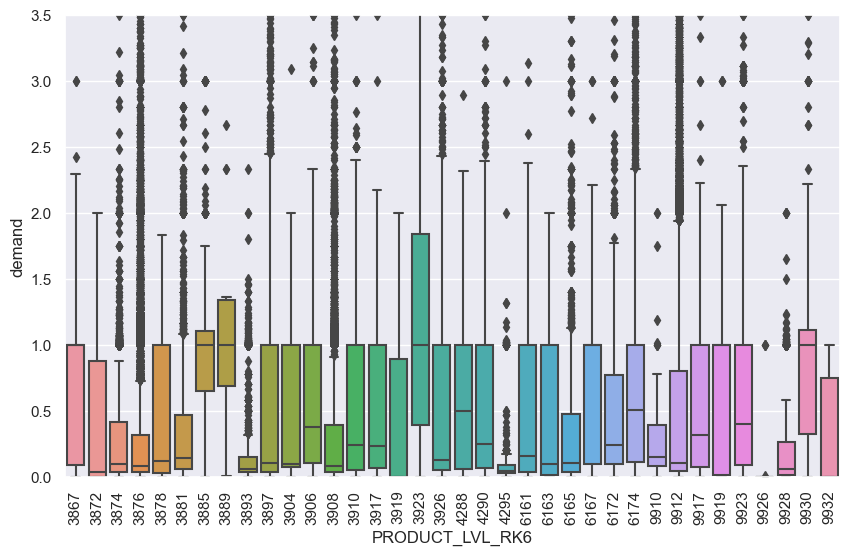

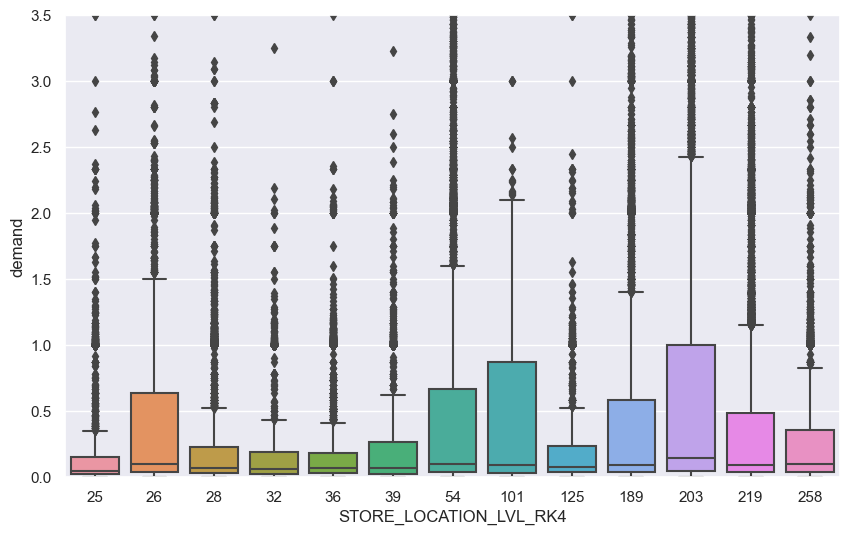

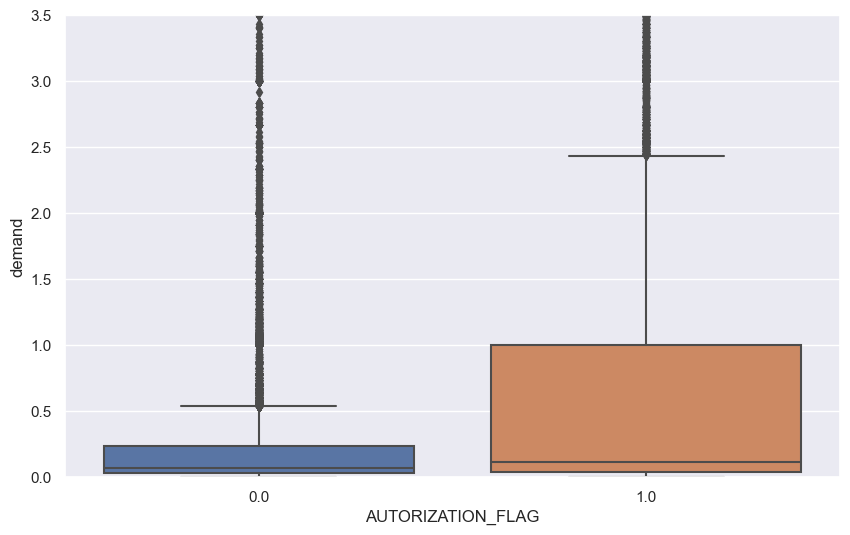

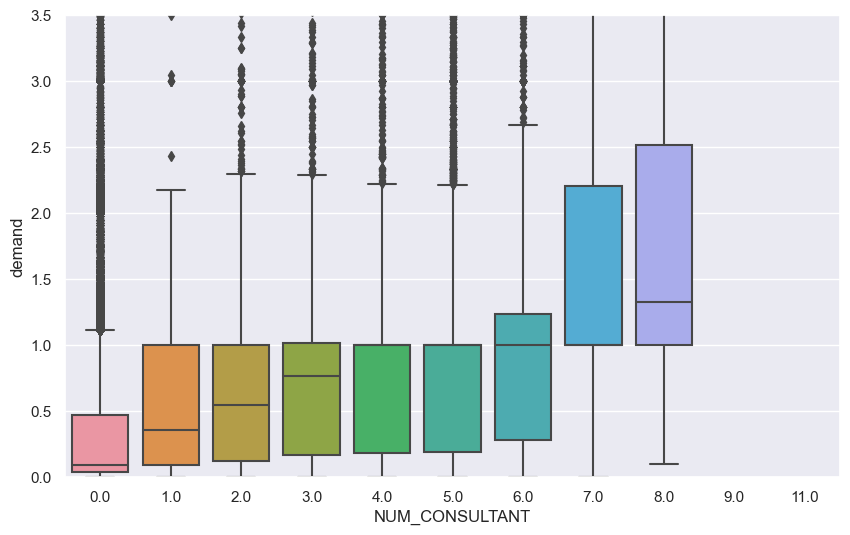

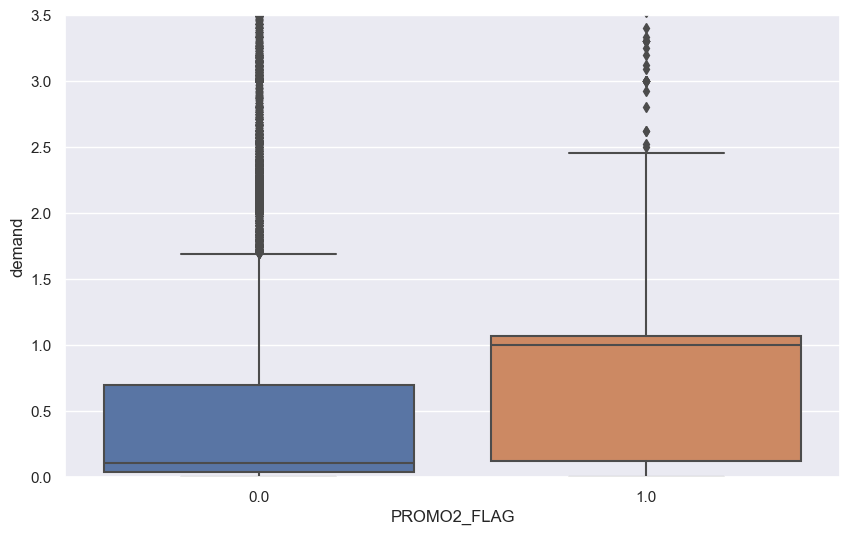

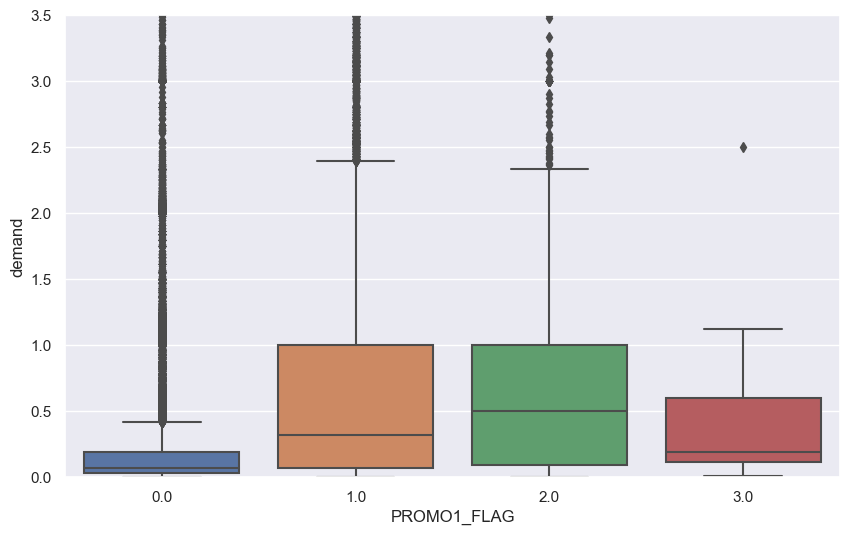

In [25]:
for col in qualitative:
    quick_boxplot(filtered_merged4, col, 'demand', vertical=col=='PRODUCT_LVL_RK6', ylim=3.5)

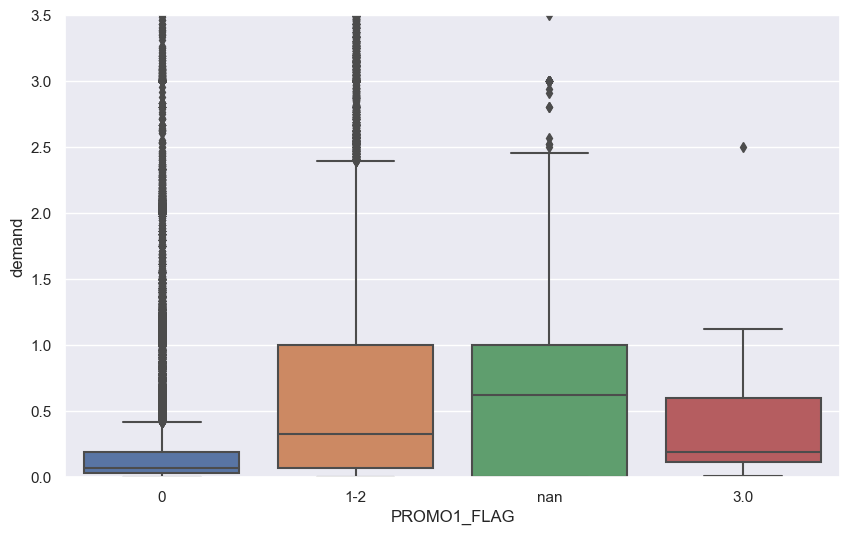

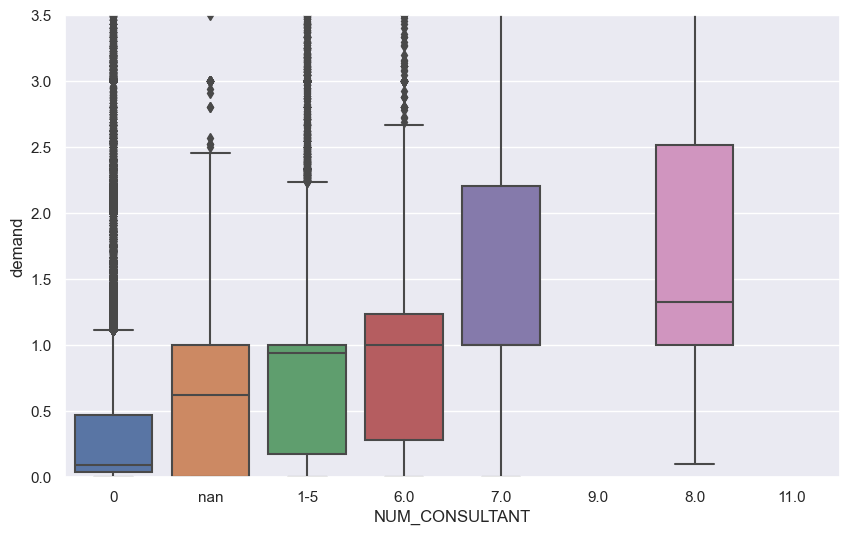

In [26]:
binned = filtered_merged4.copy()

binned['PROMO1_FLAG'] = filtered_merged4['PROMO1_FLAG'].apply(lambda x: '0' if x == 0 else ('1-2' if x == 1 or x == 2 else str(x)))
binned['NUM_CONSULTANT'] = filtered_merged4['NUM_CONSULTANT'].apply(lambda x: '0' if x == 0 else ('1-5' if x >= 1 and x <= 5 else str(x)))

for col in ['PROMO1_FLAG', 'NUM_CONSULTANT']:
    quick_boxplot(binned, col, 'demand', ylim=3.5)


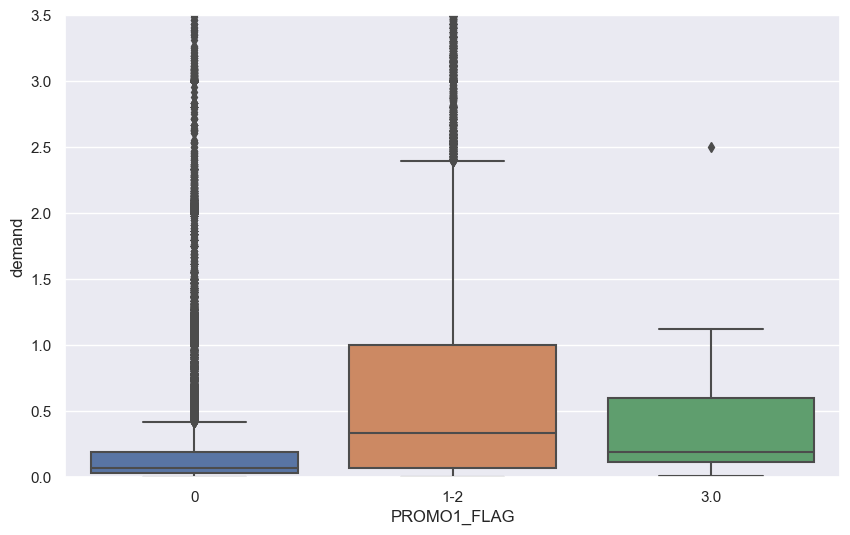

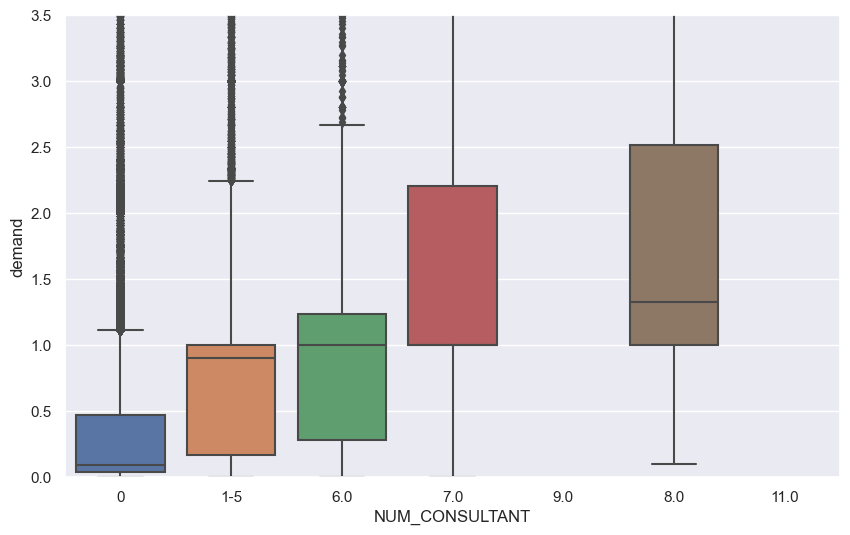

In [27]:
binned['PROMO1_FLAG'] = binned['PROMO1_FLAG'].apply(lambda x: '1-2' if x == 'nan' else x)
binned['NUM_CONSULTANT'] = binned['NUM_CONSULTANT'].apply(lambda x: '1-5' if x == 'nan' else x)

for col in ['PROMO1_FLAG', 'NUM_CONSULTANT']:
    quick_boxplot(binned, col, 'demand', ylim=3.5)

In [28]:
dataframe_new_stats(binned)

null     %null    zero      %zero  unique
period_dt                  0  0.000000       0   0.000000     156
location_id                0  0.000000       0   0.000000      41
product_id                 0  0.000000       0   0.000000    2140
demand                  9648  3.395760    5238   1.843594   16291
PROMO1_FLAG                0  0.000000       0   0.000000       3
PROMO2_FLAG             1797  0.632481  281604  99.114808       2
PRICE_REGULAR           6819  2.400051       0   0.000000    2717
PRICE_AFTER_DISC        8435  2.968826       0   0.000000   13080
NUM_CONSULTANT             0  0.000000       0   0.000000       7
AUTORIZATION_FLAG       1797  0.632481   35524  12.503212       2
id                         0  0.000000       0   0.000000  284119
STORE_LOCATION_LVL_RK4     0  0.000000       0   0.000000      13
PRODUCT_LVL_RK6            0  0.000000       0   0.000000      36

The missing values in 'AUTORIZATION_FLAG' can be imputed with the median value over the dataset. The missing values in 'PRICE_REGULAR' and 'PRICE_AFTER_DISC' are going to be imputed with the median values within each product category.

In [29]:
price_cleared = binned.copy()
price_cleared['period_dt'] = pd.to_datetime(price_cleared['period_dt'])

In [30]:
for cum in price_cleared['PRODUCT_LVL_RK6'].unique():
    price_cleared.loc[price_cleared['PRODUCT_LVL_RK6'] == cum, 'PRICE_REGULAR'] = \
        price_cleared.loc[price_cleared['PRODUCT_LVL_RK6'] == cum, 'PRICE_REGULAR'].fillna(price_cleared[price_cleared['PRODUCT_LVL_RK6'] == cum]['PRICE_REGULAR'].median())
    price_cleared.loc[price_cleared['PRODUCT_LVL_RK6'] == cum, 'PRICE_AFTER_DISC'] = \
        price_cleared.loc[price_cleared['PRODUCT_LVL_RK6'] == cum, 'PRICE_AFTER_DISC'].fillna(price_cleared[price_cleared['PRODUCT_LVL_RK6'] == cum]['PRICE_AFTER_DISC'].median())

price_cleared['AUTORIZATION_FLAG'].fillna(price_cleared['AUTORIZATION_FLAG'].median(), inplace=True)

dataframe_new_stats(price_cleared)

null     %null    zero      %zero  unique
period_dt                  0  0.000000       0   0.000000     156
location_id                0  0.000000       0   0.000000      41
product_id                 0  0.000000       0   0.000000    2140
demand                  9648  3.395760    5238   1.843594   16291
PROMO1_FLAG                0  0.000000       0   0.000000       3
PROMO2_FLAG             1797  0.632481  281604  99.114808       2
PRICE_REGULAR              0  0.000000       0   0.000000    2718
PRICE_AFTER_DISC           0  0.000000       0   0.000000   13080
NUM_CONSULTANT             0  0.000000       0   0.000000       7
AUTORIZATION_FLAG          0  0.000000   35524  12.503212       2
id                         0  0.000000       0   0.000000  284119
STORE_LOCATION_LVL_RK4     0  0.000000       0   0.000000      13
PRODUCT_LVL_RK6            0  0.000000       0   0.000000      36

In [31]:
for i in price_cleared['PROMO1_FLAG'].unique():
    print(f"{i}: {len(price_cleared[price_cleared['PROMO1_FLAG'] == i])}")

for i in price_cleared['PROMO2_FLAG'].unique():
    print(f"{i}: {len(price_cleared[price_cleared['PROMO2_FLAG'] == i])}")

0: 163979
1-2: 120032
3.0: 108
0.0: 281604
nan: 0
1.0: 718


it seems reasonable to get rid of the extremely rare labels(<=0.2% of entries actually containing this label), thus we scrap 'PROMO2_FLAG' altogether and shove the label '3' into the '1-2' bin.

In [32]:
price_cleared['PROMO1_FLAG'] = price_cleared['PROMO1_FLAG'].apply(lambda x: '1-3' if x == '1-2' or x == '3.0' else x)
price_cleared.drop(['PROMO2_FLAG'], axis=1, inplace=True)

In [33]:
for i in price_cleared['PROMO1_FLAG'].unique():
    print(f"{i}: {len(price_cleared[price_cleared['PROMO1_FLAG'] == i])}")

0: 163979
1-3: 120140


In [34]:
price_cleared[price_cleared['product_id'] == 77229].sort_values('period_dt')

period_dt  location_id  product_id    demand PROMO1_FLAG  \
116256 2016-12-26        798.0     77229.0  1.000000         1-3   
116282 2017-01-02       1034.0     77229.0  0.006494         1-3   
116286 2017-05-15        540.0     77229.0  1.000000           0   
116283 2017-08-07       1034.0     77229.0  1.000000           0   
116287 2017-08-14        540.0     77229.0  1.005479           0   
...           ...          ...         ...       ...         ...   
116285 2019-12-23       1191.0     77229.0       NaN           0   
116107 2019-12-30        764.0     77229.0       NaN           0   
116122 2019-12-30       1281.0     77229.0       NaN           0   
116012 2019-12-30        525.0     77229.0       NaN           0   
116055 2019-12-30        557.0     77229.0       NaN           0   

        PRICE_REGULAR  PRICE_AFTER_DISC NUM_CONSULTANT  AUTORIZATION_FLAG  \
116256    3499.000000       2624.250000              0                1.0   
116282    3399.000000       2549.250000              0                1.0   
116286    3499.000000       2799.200000              0                1.0   
116283    3456.142857       2592.107143              0                1.0   
116287    3499.000000       2749.214286              0                1.0   
...               ...               ...            ...                ...   
116285    3649.000000       2189.400000              0                1.0   
116107    3649.000000       2189.400000              0                1.0   
116122    3649.000000       2736.750000              0                1.0   
116012    3649.000000       2371.850000              0                1.0   
116055    3649.000000       2189.400000              0                1.0   

            id  STORE_LOCATION_LVL_RK4  PRODUCT_LVL_RK6  
116256  124239                     203             9923  
116282  124252                     203             9923  
116286  124207                      26             9923  
116283  124253                     203             9923  
116287  124208                      26             9923  
...        ...                     ...              ...  
116285  124189                      28             9923  
116107  124186                     219             9923  
116122  124191                     203             9923  
116012  124180                      54             9923  
116055  124181                      54             9923  

[280 rows x 12 columns]

In [35]:
weekd = price_cleared.copy()

weekd['period_dt'] = weekd['period_dt'] - pd.to_timedelta(weekd['period_dt'].dt.weekday, unit='D')
weekd.head(10).sort_values(by='period_dt')

period_dt  location_id  product_id    demand PROMO1_FLAG  PRICE_REGULAR  \
1 2017-01-02        425.0     22939.0  0.005479         1-3    3399.000000   
2 2017-02-27        425.0     22939.0  1.000000         1-3    3399.000000   
3 2017-03-20        425.0     22939.0  0.002740           0    3399.000000   
4 2018-01-01        425.0     22939.0  0.002740         1-3    3399.000000   
5 2018-01-08        425.0     22939.0  1.021918           0    3506.142857   
6 2018-01-15        425.0     22939.0  0.022152           0    3549.000000   
7 2018-01-22        425.0     22939.0  0.022152           0    3549.000000   
8 2018-01-29        425.0     22939.0  0.022152           0    3549.000000   
9 2018-02-05        425.0     22939.0  0.022152           0    3549.000000   
0 2019-12-30        425.0     22939.0       NaN           0    3649.000000   

   PRICE_AFTER_DISC NUM_CONSULTANT  AUTORIZATION_FLAG  id  \
1       2549.250000              0                1.0  75   
2       2549.250000              0                1.0  76   
3       2549.250000              0                1.0  77   
4       2549.250000              0                1.0  78   
5       2629.607143              0                1.0  79   
6       2661.750000              0                1.0  80   
7       2661.750000              0                1.0  81   
8       2661.750000              0                1.0  82   
9       2661.750000              0                1.0  83   
0       2736.750000              0                0.0   1   

   STORE_LOCATION_LVL_RK4  PRODUCT_LVL_RK6  
1                     203             3876  
2                     203             3876  
3                     203             3876  
4                     203             3876  
5                     203             3876  
6                     203             3876  
7                     203             3876  
8                     203             3876  
9                     203             3876  
0                     203             3876

Text(0.5, 1.0, 'Total demand over time')

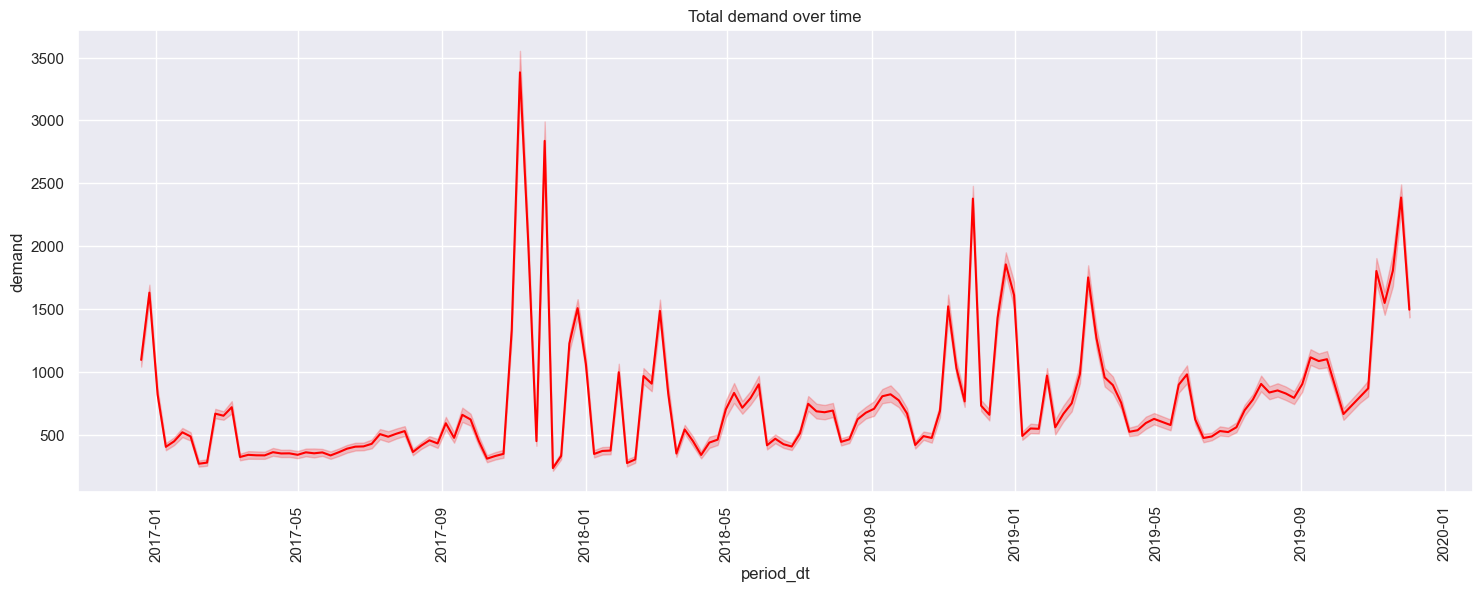

In [90]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.lineplot(data=weekd, x='period_dt', y='demand', estimator='sum', ax=ax, color='red')
ax.tick_params(axis='x', rotation=90)
ax.set_title(f"Total demand over time")

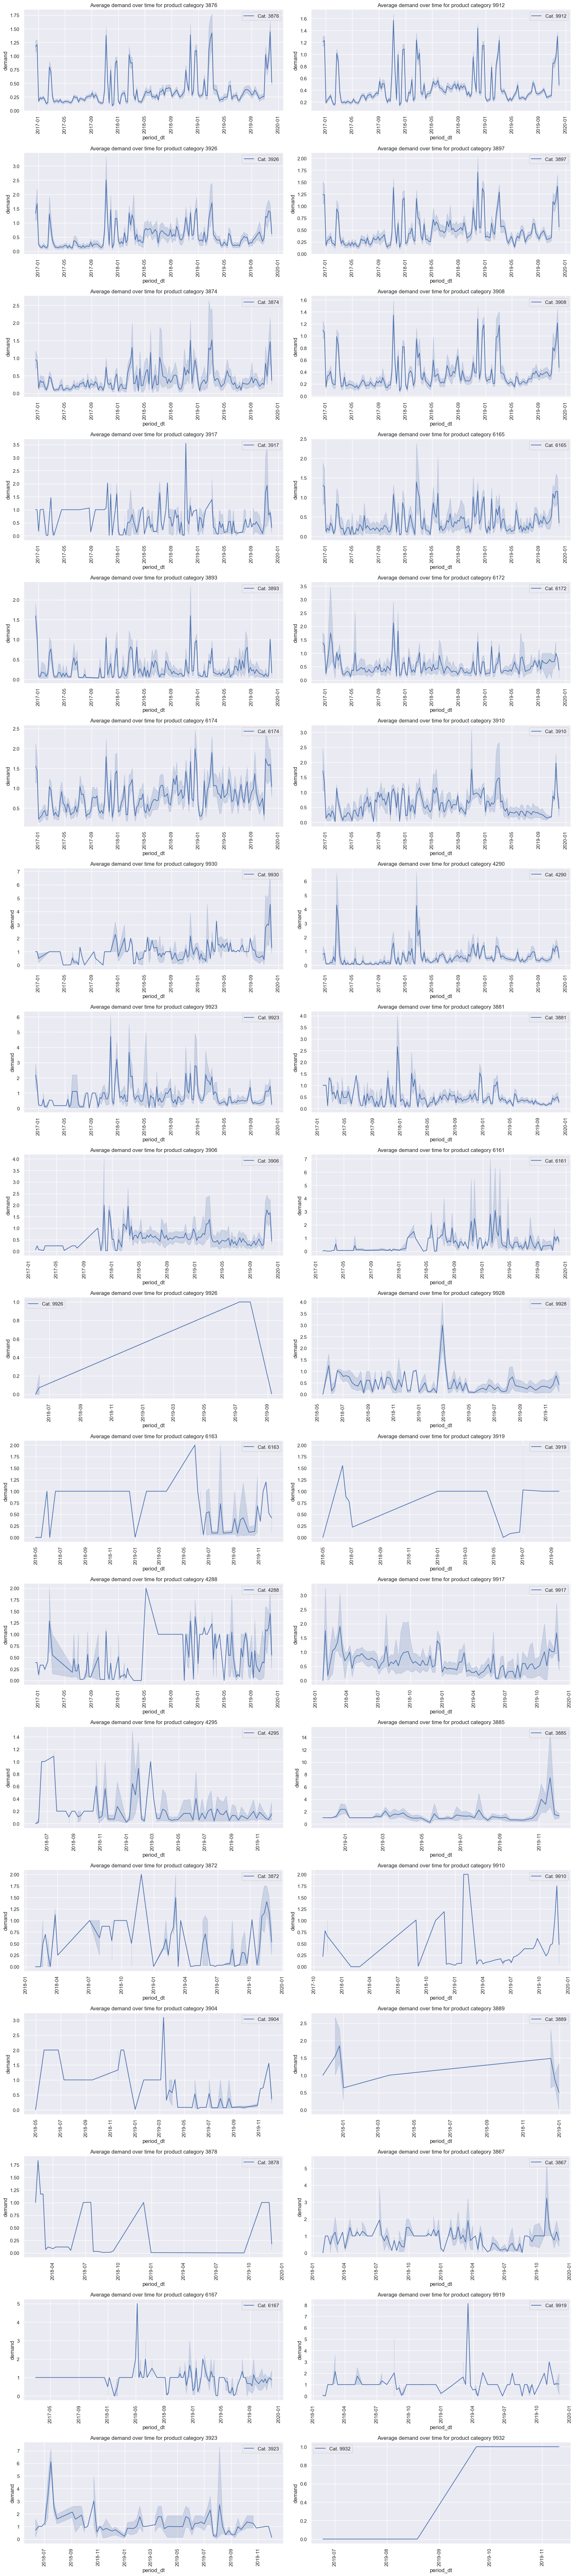

In [37]:
fig, ax = plt.subplots(figsize=(18, 80), nrows=18, ncols=2)
ax = ax.flatten()
counter = 0

for dix in weekd['PRODUCT_LVL_RK6'].unique():

    sns.lineplot(data=weekd[weekd['PRODUCT_LVL_RK6'] == dix], x='period_dt', y='demand', estimator='mean', ax=ax[counter], label=f"Cat. {dix}")
    ax[counter].tick_params(axis='x', rotation=90)
    ax[counter].set_title(f"Average demand over time for product category {dix}")
    counter += 1

plt.tight_layout()

Text(0.5, 1.0, 'Average demand over time in weeks')

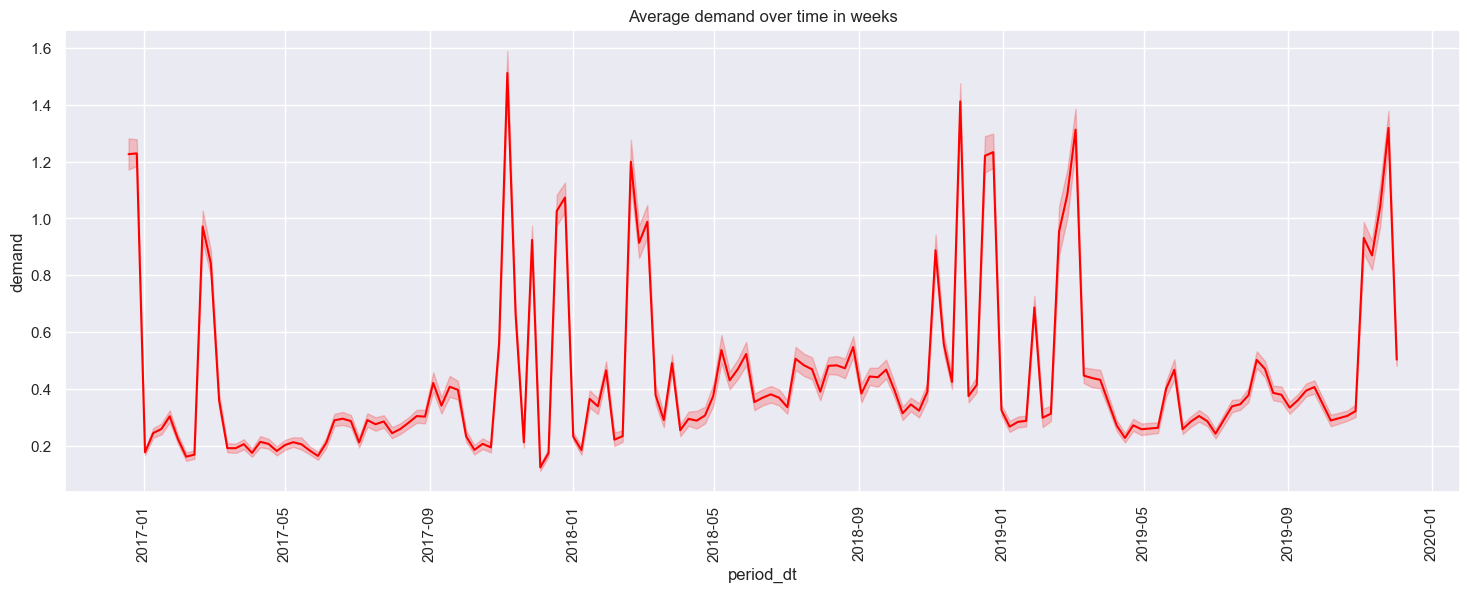

In [93]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.lineplot(data=weekd, x='period_dt', y='demand', estimator='mean', ax=ax, color='red')
ax.tick_params(axis='x', rotation=90)
ax.set_title(f"Average demand over time in weeks")

(0.0, 2.0)

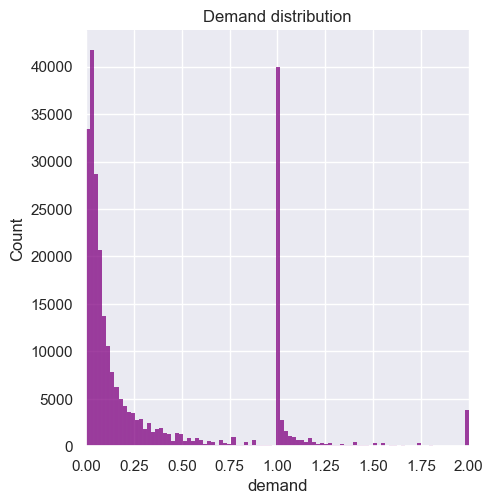

In [91]:
sns.displot(weekd, x='demand', kind='hist', color='purple')
plt.title('Demand distribution')
plt.xlim((0, 2))

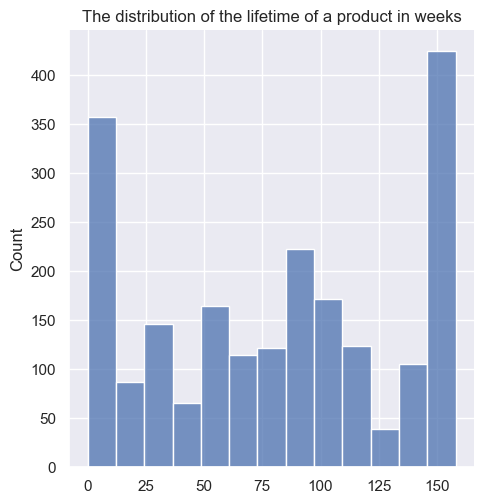

In [39]:
def calculate_duration(df: pd.DataFrame, date_col: str, group_col: str):
    dfc = df.copy()
    dfc[date_col] = pd.to_datetime(dfc[date_col])
    grouped = df.groupby(group_col)[date_col].agg(['min', 'max'])
    date_diff = ((grouped['max'] - grouped['min']).dt.days) / 7
    
    return date_diff

weekssinceentry = calculate_duration(weekd, 'period_dt', 'product_id')

sns.displot(weekssinceentry, kind='hist')
plt.title('The distribution of the lifetime of a product in weeks');

In [94]:
dataframe_new_stats(weekd)

null    %null   zero      %zero  unique
period_dt                  0  0.00000      0   0.000000     156
location_id                0  0.00000      0   0.000000      41
product_id                 0  0.00000      0   0.000000    2140
demand                  9648  3.39576   5238   1.843594   16291
PROMO1_FLAG                0  0.00000      0   0.000000       2
PRICE_REGULAR              0  0.00000      0   0.000000    2718
PRICE_AFTER_DISC           0  0.00000      0   0.000000   13080
NUM_CONSULTANT             0  0.00000      0   0.000000       7
AUTORIZATION_FLAG          0  0.00000  35524  12.503212       2
id                         0  0.00000      0   0.000000  284119
STORE_LOCATION_LVL_RK4     0  0.00000      0   0.000000      13
PRODUCT_LVL_RK6            0  0.00000      0   0.000000      36

In [40]:
acfs = []
pacfs = []

for dix in weekd['PRODUCT_LVL_RK6'].unique():
    pacfs.append(np.array(sm2.tsa.stattools.pacf(weekd[weekd['PRODUCT_LVL_RK6'] == dix].dropna().groupby(by='period_dt')['demand'].mean())))
    acfs.append(np.array(sm2.tsa.stattools.acf(weekd[weekd['PRODUCT_LVL_RK6'] == dix].dropna().groupby(by='period_dt')['demand'].mean())))

In [41]:
acf_avg = np.mean([x[:15] for x in acfs if x.size >= 15], axis=0)
pacf_avg = np.mean([x[:15] for x in pacfs if x.size >= 15], axis=0)

<Figure size 1200x600 with 0 Axes>

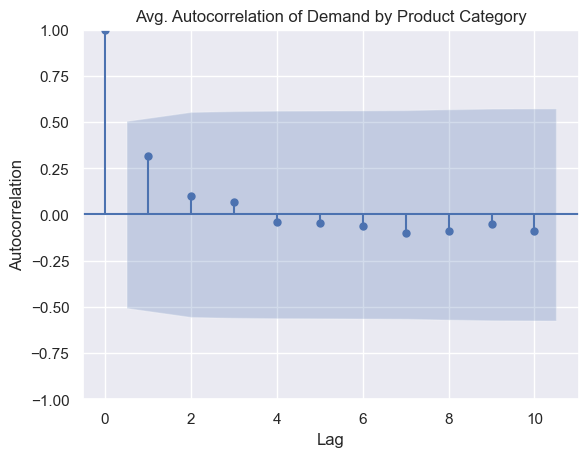

In [42]:
#acfdemand = sm2.tsa.stattools.acf(weekd.dropna().groupby(by='period_dt')['demand'].mean())

plt.figure(figsize=(12, 6))
sm2.graphics.tsa.plot_acf(acf_avg, lags=10, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Avg. Autocorrelation of Demand by Product Category')
plt.grid(True)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1200x600 with 0 Axes>

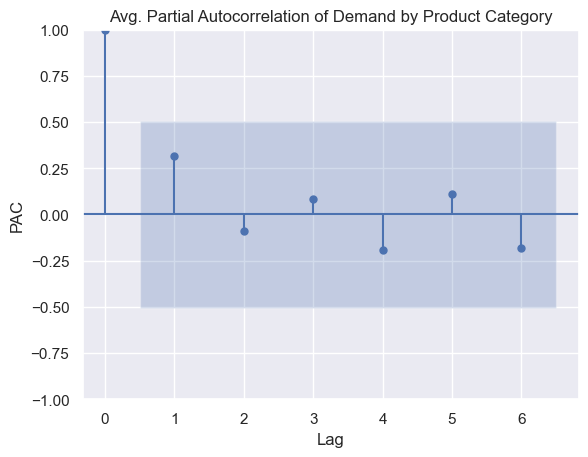

In [43]:
plt.figure(figsize=(12, 6))
sm2.graphics.tsa.plot_pacf(pacf_avg, lags=6, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('PAC')
plt.title('Avg. Partial Autocorrelation of Demand by Product Category')
plt.grid(True)
plt.show()

### chapter 2: feature engineering

**ideas:**
- demand average over a category on a particular week
- ratio of price to average price of products from the same category
- discount percentage
- demand in the past(can use pacf)
- account for seasonality(granular date features?)

In [44]:
doydf = weekd.copy()

doydf['weekofyear'] = doydf['period_dt'].dt.weekofyear
doydf['month'] = doydf['period_dt'].dt.month
doydf['year'] = doydf['period_dt'].dt.year
doydf.drop(['period_dt'], axis=1, inplace=True)

doydf['location_id'] = doydf['location_id'].astype(str)
doydf['product_id'] = doydf['product_id'].astype(str)
doydf['AUTORIZATION_FLAG'] = doydf['AUTORIZATION_FLAG'].astype(str)
doydf['STORE_LOCATION_LVL_RK4'] = doydf['STORE_LOCATION_LVL_RK4'].astype(str)
doydf['PRODUCT_LVL_RK6'] = doydf['PRODUCT_LVL_RK6'].astype(str)

/var/folders/54/sdchpz1d0cd6rp15x31xtjlh0000gn/T/ipykernel_30531/736140934.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  doydf['weekofyear'] = doydf['period_dt'].dt.weekofyear


In [45]:
doydf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284119 entries, 0 to 284118
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   location_id             284119 non-null  object 
 1   product_id              284119 non-null  object 
 2   demand                  274471 non-null  float64
 3   PROMO1_FLAG             284119 non-null  object 
 4   PRICE_REGULAR           284119 non-null  float64
 5   PRICE_AFTER_DISC        284119 non-null  float64
 6   NUM_CONSULTANT          284119 non-null  object 
 7   AUTORIZATION_FLAG       284119 non-null  object 
 8   id                      284119 non-null  int64  
 9   STORE_LOCATION_LVL_RK4  284119 non-null  object 
 10  PRODUCT_LVL_RK6         284119 non-null  object 
 11  weekofyear              284119 non-null  int64  
 12  month                   284119 non-null  int64  
 13  year                    284119 non-null  int64  
dtypes: float64(3), int64

In [46]:
dataframe_new_stats(doydf)

null    %null  zero     %zero  unique
location_id                0  0.00000     0  0.000000      41
product_id                 0  0.00000     0  0.000000    2140
demand                  9648  3.39576  5238  1.843594   16291
PROMO1_FLAG                0  0.00000     0  0.000000       2
PRICE_REGULAR              0  0.00000     0  0.000000    2718
PRICE_AFTER_DISC           0  0.00000     0  0.000000   13080
NUM_CONSULTANT             0  0.00000     0  0.000000       7
AUTORIZATION_FLAG          0  0.00000     0  0.000000       2
id                         0  0.00000     0  0.000000  284119
STORE_LOCATION_LVL_RK4     0  0.00000     0  0.000000      13
PRODUCT_LVL_RK6            0  0.00000     0  0.000000      36
weekofyear                 0  0.00000     0  0.000000      52
month                      0  0.00000     0  0.000000      12
year                       0  0.00000     0  0.000000       4

Rows containing NAN demand values will be eliminated before using the dataset for training purposes, it has not been done on the EDA stage due to the fact that we will need them on the test stage.

### chapter 3: ML models

we finna roll with CatBoost and Tensorflow Model.

In [62]:
featureset = sorted(list(set(doydf.columns) - set(['id', 'product_id', 'location_id', 'demand'])))

quantiative = set(['PRICE_AFTER_DISC', 'PRICE_REGULAR'])
qualitative = set(featureset) - quantiative

nonnandf = doydf.dropna()
nonnandf = nonnandf.reindex(sorted(nonnandf.columns), axis=1)

In [64]:
nonnandf[featureset]

AUTORIZATION_FLAG NUM_CONSULTANT  PRICE_AFTER_DISC  PRICE_REGULAR  \
1                    1.0              0       2549.250000    3399.000000   
2                    1.0              0       2549.250000    3399.000000   
3                    1.0              0       2549.250000    3399.000000   
4                    1.0              0       2549.250000    3399.000000   
5                    1.0              0       2629.607143    3506.142857   
...                  ...            ...               ...            ...   
284114               0.0              0        974.390000    1499.000000   
284115               0.0              0        974.390000    1499.000000   
284116               0.0              0        974.390000    1499.000000   
284117               0.0              0        974.390000    1499.000000   
284118               0.0              0        699.500000    1399.000000   

       PRODUCT_LVL_RK6 PROMO1_FLAG STORE_LOCATION_LVL_RK4  month  weekofyear  \
1                 3876         1-3                    203      1           1   
2                 3876         1-3                    203      2           9   
3                 3876           0                    203      3          12   
4                 3876         1-3                    203      1           1   
5                 3876           0                    203      1           2   
...                ...         ...                    ...    ...         ...   
284114            4288           0                    258     12          49   
284115            4288           0                    258     12          50   
284116            4288         1-3                    258      1           1   
284117            4288           0                    258      1           2   
284118            4288         1-3                    258      8          33   

        year  
1       2017  
2       2017  
3       2017  
4       2018  
5       2018  
...      ...  
284114  2017  
284115  2017  
284116  2018  
284117  2018  
284118  2019  

[274471 rows x 10 columns]

#### 3.1 CatBoost

In [65]:
catfeat = [0, 1, 4, 5, 6, 7, 8, 9]

X_train, X_val, y_train, y_val = train_test_split(nonnandf[featureset], nonnandf['demand'], test_size=0.2, random_state=69)

In [66]:
from catboost import CatBoostRegressor, Pool, metrics, cv
from sklearn.metrics import accuracy_score

catbust = CatBoostRegressor(
    loss_function='MAE',
    learning_rate=0.05,
    iterations=250,
    min_data_in_leaf=12,
    max_leaves=64,
    random_seed=69,
)

catbust.fit(X_train, y_train, 
        cat_features=catfeat, 
        eval_set=(X_val, y_val),
        verbose=False
)

print(f"Fit: {catbust.is_fitted()}")
print(f'Parameters: {catbust.get_params()}')
print(f"Tree count: {catbust.tree_count_}")
print(f"Best score: {catbust.get_best_score()}")

Fit: True
Parameters: {'iterations': 250, 'learning_rate': 0.05, 'loss_function': 'MAE', 'random_seed': 69, 'min_data_in_leaf': 12, 'max_leaves': 64}
Tree count: 250
Best score: {'learn': {'MAE': 0.2905099554287576}, 'validation': {'MAE': 0.28984210502200186}}


Text(0.5, 1.0, 'Feature importance')

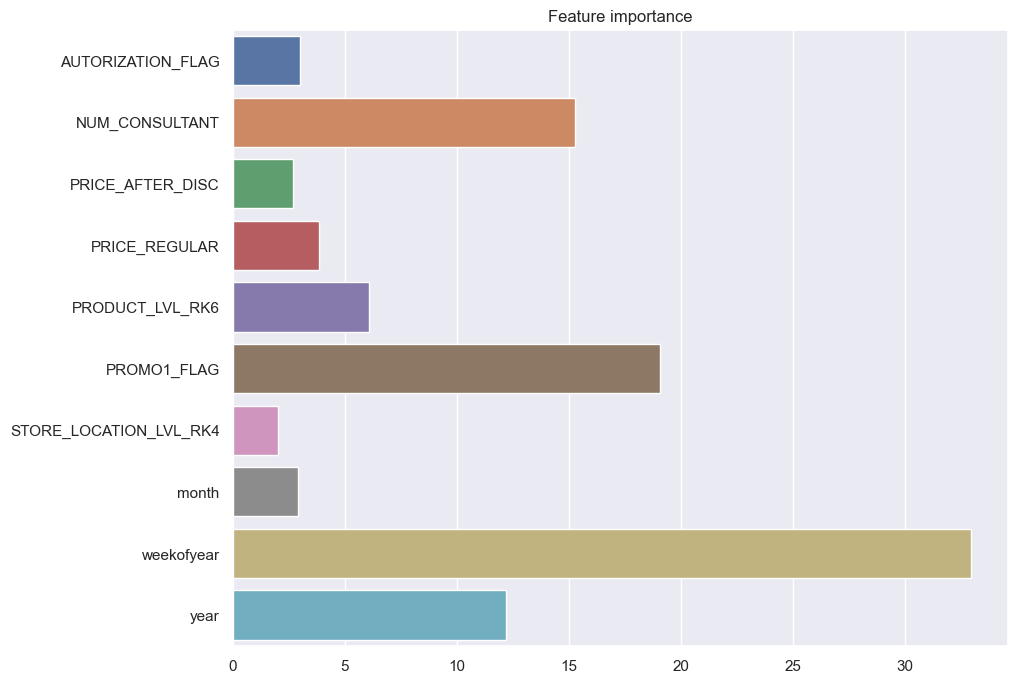

In [67]:
nigga = catbust.feature_importances_
plt.figure(figsize=(10,8))
sns.barplot(x=nigga, y=nonnandf[featureset].columns)
plt.title("Feature importance")

In [68]:
testset = doydf[doydf['id'].isin(test_df['id'])].copy()
testset

location_id product_id  demand PROMO1_FLAG  PRICE_REGULAR  \
164         1162.0    22939.0     NaN           0         3649.0   
8082        1162.0    23162.0     NaN           0         3799.0   
8724        1162.0    23163.0     NaN           0         3799.0   
14472        798.0    23632.0     NaN           0         3999.0   
14744       1347.0    23633.0     NaN           0         3999.0   
...            ...        ...     ...         ...            ...   
282491      1316.0   138545.0     NaN         1-3         5150.0   
282500      1316.0   139129.0     NaN         1-3         4899.0   
282501      1328.0   139129.0     NaN         1-3         4899.0   
284046      1328.0   123260.0     NaN           0         4949.0   
284091       504.0   130619.0     NaN         1-3         3949.0   

        PRICE_AFTER_DISC NUM_CONSULTANT AUTORIZATION_FLAG      id  \
164              2189.40              0               1.0      16   
8082             2279.40              0               1.0    7867   
8724             2849.25              0               1.0    8667   
14472            2399.40              0               1.0   14835   
14744            2999.25              0               1.0   14959   
...                  ...            ...               ...     ...   
282491           2575.00              0               1.0  203824   
282500           2449.50              0               1.0  203977   
282501           2449.50              0               1.0  203978   
284046           3216.97              0               1.0  199653   
284091           1974.50              0               1.0  201065   

       STORE_LOCATION_LVL_RK4 PRODUCT_LVL_RK6  weekofyear  month  year  
164                       189            3876           1     12  2019  
8082                      189            9912           1     12  2019  
8724                      189            9912          51     12  2019  
14472                     203            9912          52     12  2019  
14744                     189            9912           1     12  2019  
...                       ...             ...         ...    ...   ...  
282491                    203            9912          52     12  2019  
282500                    203            9912          52     12  2019  
282501                     54            9912          52     12  2019  
284046                     54            3876          50     12  2019  
284091                     25            9912           1     12  2019  

[593 rows x 14 columns]

In [69]:
sweetprecious = pd.DataFrame({'id': testset['id'].copy(), 'demand': catbust.predict(testset[featureset])})
sweetprecious

id    demand
164         16  0.036584
8082      7867  0.089279
8724      8667  0.242916
14472    14835  0.299671
14744    14959  0.090397
...        ...       ...
282491  203824  0.848602
282500  203977  0.872611
282501  203978  0.865979
284046  199653  0.080986
284091  201065  0.175550

[593 rows x 2 columns]

In [70]:
sweetprecious.to_csv('mysub.csv', sep=',', index=False)

#### 3.2 Tensorflow

In [72]:
train, test = train_test_split(nonnandf[list(featureset) + ['demand']], test_size=0.2, random_state=69)
train, val = train_test_split(nonnandf[list(featureset) + ['demand']], test_size=0.2, random_state=69)

In [73]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def df_to_dataset(df, target_name, batch_size=32):
  dataframe = df.copy()
  labels = dataframe.pop(target_name)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

batch_size = 256
trainds = df_to_dataset(train, 'demand', batch_size)
valds = df_to_dataset(val, 'demand', batch_size)
testds = df_to_dataset(test, 'demand', batch_size)

In [74]:
[(train_features, label_batch)] = trainds.take(1)

def get_normalization_layer(name, dataset):
    normalizer = layers.Normalization(axis=None)
    feature_ds = dataset.map(lambda x, y: x[name])
    normalizer.adapt(feature_ds)

    return normalizer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)

    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

    return lambda feature: encoder(index(feature))

2023-06-23 02:35:12.193418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int64 and shape [219576]
	 [[{{node Placeholder/_8}}]]
2023-06-23 02:35:12.194190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int64 and shape [219576]
	 [[{{node Placeholder/_8}}]]


In [75]:
all_inputs = []
encoded_features = []

for quant in quantiative:
    numeric_col = tf.keras.Input(shape=(1,), name=quant)
    normalization_layer = get_normalization_layer(quant, trainds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

for quat in qualitative:
    if quat in ['weekofyear', 'month', 'year']:
        coltype = 'int64'
    else:
        coltype = 'string'
    categorical_col = tf.keras.Input(shape=(1,), name=quat, dtype=coltype)
    encoding_layer = get_category_encoding_layer(name=quat, dataset=trainds, dtype=coltype, max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

2023-06-23 02:35:12.406487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype int64 and shape [219576]
	 [[{{node Placeholder/_9}}]]
2023-06-23 02:35:12.407256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype string and shape [219576]
	 [[{{node Placeholder/_6}}]]
2023-06-23 02:35:14.893163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [

In [79]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = keras.layers.Dense(200, activation="relu")(all_features)
x = keras.layers.BatchNormalization(axis=1)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(100, activation="relu")(x)
x = keras.layers.Dense(75, activation="relu")(x)
x = keras.layers.BatchNormalization(axis=1)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(60, activation="relu")(x)
x = keras.layers.Dense(50, activation="relu")(x)
x = keras.layers.BatchNormalization(axis=1)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(45, activation="sigmoid")(x)
x = layers.Dense(40, activation="sigmoid")(x)
x = keras.layers.BatchNormalization(axis=1)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(30, activation="sigmoid")(x)
x = layers.Dense(20, activation="sigmoid")(x)
x = keras.layers.BatchNormalization(axis=1)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(13, activation="sigmoid")(x)
x = layers.Dense(13, activation="sigmoid")(x)
output = layers.Dense(1, activation="sigmoid")(x)

In [80]:
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 month (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 STORE_LOCATION_LVL_RK4 (InputL  [(None, 1)]         0           []                               
 ayer)                                                                                            
                                                                                                  
 year (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 PRODUCT_LVL_RK6 (InputLayer)   [(None, 1)]          0           []                         

 ncoding)                                                                                         
                                                                                                  
 category_encoding_5 (CategoryE  (None, 5)           0           ['string_lookup_3[0][0]']        
 ncoding)                                                                                         
                                                                                                  
 category_encoding_6 (CategoryE  (None, 5)           0           ['integer_lookup_2[0][0]']       
 ncoding)                                                                                         
                                                                                                  
 category_encoding_7 (CategoryE  (None, 3)           0           ['string_lookup_4[0][0]']        
 ncoding)                                                                                         
          

In [81]:
model.fit(trainds, batch_size=256, epochs=86, validation_data=valds, verbose=0)

In [82]:
loss, accuracy = model.evaluate(testds)
print("Accuracy", accuracy)
print("Loss", loss)

 14/215 [>.............................] - ETA: 0s - loss: 0.2916 - accuracy: 0.0840 

2023-06-23 02:51:44.653632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype string and shape [54895]
	 [[{{node Placeholder/_6}}]]
2023-06-23 02:51:44.655324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [54895]
	 [[{{node Placeholder/_0}}]]


215/215 [==============================] - 1s 3ms/step - loss: 0.2971 - accuracy: 0.0791
Accuracy 0.07911467552185059
Loss 0.29713690280914307


- посмотреть дядины лекции
- аутлаер деманд убрать
- добавить время продукта на рынке
- оставить только декабрь
- The ratio of price to average price of products from the same subtype
- Average brand sales within a group of products in the first week of products in stock - historical data grouped by a category
- monthly demand avg
- мб дисконт/цена
- average of demand over a year
- how many products do u have per category tho?
- акф/пакф на одной паре товар магазин
- комбинация разныхх методов
- The original version of Rule-Based Forecasting was based on combined extrapolations from four methods: the random walk, linear regression against time, Holt=s linear exponential smoothing, and Brown=s linear exponential smoothing.
- лаговые фичи
- вернуть удаленные фичи и посмотреть че будет